In [1]:
# Importation des bibliothèques nécessaires
import spacy
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Chargement du modèle linguistique français de spaCy
nlp = spacy.load("fr_core_news_sm")

In [26]:

# Fonction pour extraire les entités nommées d'un fichier
def extract_named_entities(file_path):
    nlp = spacy.load("fr_core_news_sm")  # 确保使用合适的模型
    with open(file_path, "r", encoding="utf-8") as file:
        text = file.read()
        doc = nlp(text)
        entities = []
        for ent in doc.ents:
            # 生成BIO标签
            start = ent.start
            bio_tags = []
            for i, token in enumerate(doc[start:ent.end]):
                if i == 0:
                    bio_tags.append("B-" + ent.label_)  # Beginning
                else:
                    bio_tags.append("I-" + ent.label_)  # Inside

            # 将BIO标签和其他信息存储在字典中
            entity_info = {
                "text": ent.text,
                "start": ent.start_char,
                "end": ent.end_char,
                "label": ent.label_,
                "BIO": bio_tags  # 添加BIO标签列表
            }
            entities.append(entity_info)
        return entities

# Fonction pour comparer les entités entre deux ensembles (référence et OCR)
def compare_entities(ref_entities, ocr_entities):
    true_positive = 0
    false_positive = 0
    false_negative = 0

    for ref_entity in ref_entities:
        found_match = False
        for ocr_entity in ocr_entities:
            if ref_entity["text"] == ocr_entity["text"]:
                true_positive += 1
                found_match = True
                break
        if not found_match:
            false_negative += 1

    false_positive = len(ocr_entities) - true_positive
    true_negative = 0  

    return true_positive, false_positive, false_negative


# Fonction pour calculer la précision, le rappel et le score F1
def calculate_metrics(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1_score



# Fonction pour annoter les barres dans un graphique à barres
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

        
# Fonction pour annoter les POS et enregistrer les résultats
def annotate_pos(file_path, output_file):
    with open(file_path, "r", encoding="utf-8") as file:
        text = file.read()
        doc = nlp(text)
     
        with open(output_file, "w", encoding="utf-8") as outfile:
            for token in doc:
                outfile.write(f"{token.text}\t{token.pos_}\n")
                
                
                
                
# Fonction pour compter les POS dans les entités nommées
def count_pos_in_entities(pos_file, entities):
    pos_counts = {}
    with open(pos_file, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) >= 2:
                word, pos_tag = parts[0], parts[1]
                
                if any(word == entity['text'] for entity in entities):
                    if pos_tag in pos_counts:
                        pos_counts[pos_tag] += 1
                    else:
                        pos_counts[pos_tag] = 1
            else:
                continue  # Ignorer les lignes qui ne correspondent pas au format attendu
    return pos_counts




# Fonction pour tracer les distributions des POS
def plot_pos_counts(pos_counts, title):
    plt.figure(figsize=(10, 6))
    plt.bar(pos_counts.keys(), pos_counts.values(), color='skyblue')
    plt.title(title)
    plt.xlabel('Part of Speech')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    
# Fonction pour extraire les tokens de type 'PROPN'   
def extract_propn_tokens(file_path):
    propn_tokens = []
    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
           
            if not line.strip():
                continue
         
            parts = line.strip().split("\t")
            if len(parts) == 2:
                token, pos_tag = parts
                if pos_tag == "PROPN":
                    propn_tokens.append(token)
    return propn_tokens


# Fonction pour calculer les métriques de performance
def calculate_performance_metrics(intersection, reference_entities, ocr_tokens):
    TP = len(intersection)  # True Positives
    FP = len(ocr_tokens - intersection)  # False Positives
    FN = len(reference_entities - intersection)  # False Negatives

    Precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    Recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1_Score = 2 * (Precision * Recall) / (Precision + Recall) if (Precision + Recall) > 0 else 0

    return Precision, Recall, F1_Score


# Fonction pour dessiner un diagramme de Venn
def plot_venn(set1, set2, title, labels=('NER', 'PROPN')):
    plt.figure(figsize=(8, 8))
    venn2([set1, set2], set_labels=labels)
    plt.title(title)
    plt.show()
    
    
# Fonction pour charger les entités nommées depuis un fichier JSON  
def load_named_entities(json_file):
    with open(json_file, "r", encoding="utf-8") as file:
        entities = json.load(file)
    return entities

In [27]:
#step1

#dash
# Extraire les entités nommées
ref_entities = extract_named_entities("DATA-ELTeC/DASH/REF/DASH_chateau-de-Pinon-V1_PP.txt")
# Sauvegarder les résultats des entités nommées de la version REF dans un fichier JSON
with open("ref_named_entities.json", "w", encoding="utf-8") as outfile:
    json.dump(ref_entities, outfile, ensure_ascii=False, indent=4)


kraken_entities = extract_named_entities("DATA-ELTeC/DASH/DASH_kraken/DASH_chateau-de-Pinon-V1_Kraken-base.txt")

with open("kraken_named_entities.json", "w", encoding="utf-8") as outfile:
    json.dump(kraken_entities, outfile, ensure_ascii=False, indent=4)


tesseract_entities = extract_named_entities("DATA-ELTeC/DASH/DASH_TesseractFra-PNG/DASH_chateau-de-Pinon-V1_TesseractFra-PNG.txt")

with open("tesseract_named_entities.json", "w", encoding="utf-8") as outfile:
    json.dump(tesseract_entities, outfile, ensure_ascii=False, indent=4)

#daudet    

daudet_ref_entities = extract_named_entities("DATA-ELTeC/DAUDET/REF/DAUDET_petit-chose_PP.txt")

with open("daudet_ref_named_entities.json", "w", encoding="utf-8") as outfile:
    json.dump(daudet_ref_entities, outfile, ensure_ascii=False, indent=4)    
    
daudet_kraken_entities = extract_named_entities("DATA-ELTeC/DAUDET/DAUDET_kraken/DAUDET_petit-chose_Kraken-base.txt")

with open("daudet_kraken_named_entities.json", "w", encoding="utf-8") as outfile:
    json.dump(daudet_kraken_entities, outfile, ensure_ascii=False, indent=4)    
        
daudet_tesseract_entities = extract_named_entities("DATA-ELTeC/DAUDET/DAUDET_TesseractFra-PNG/DAUDET_petit-chose_TesseractFra-PNG.txt")

with open("daudet_tesseract_named_entities.json", "w", encoding="utf-8") as outfile:
    json.dump(daudet_tesseract_entities, outfile, ensure_ascii=False, indent=4)    
        
    

    
#flaubert

flaubert_ref_entities = extract_named_entities("DATA-ELTeC/FLAUBERT/REF/FLAUBERT_education-sentimentale_PP.txt")

with open("flaubert_ref_named_entities.json", "w", encoding="utf-8") as outfile:
    json.dump(flaubert_ref_entities, outfile, ensure_ascii=False, indent=4)    
    
flaubert_kraken_entities = extract_named_entities("DATA-ELTeC/FLAUBERT/FLAUBERT_kraken/FLAUBERT_education-sentimentale_Kraken-base.txt")

with open("flaubert_kraken_named_entities.json", "w", encoding="utf-8") as outfile:
    json.dump(flaubert_kraken_entities, outfile, ensure_ascii=False, indent=4)    
        
flaubert_tesseract_entities = extract_named_entities("DATA-ELTeC/FLAUBERT/FLAUBERT_TesseractFra-PNG/FLAUBERT_education-sentimentale_TesseractFra-PNG.txt")

with open("flaubert_tesseract_named_entities.json", "w", encoding="utf-8") as outfile:
    json.dump(flaubert_tesseract_entities, outfile, ensure_ascii=False, indent=4)  

    
    

#MAUPASSANT

MAUPASSANT_ref_entities = extract_named_entities("DATA-ELTeC/MAUPASSANT/REF/MAUPASSANT_une-vie_PP.txt")

with open("MAUPASSANT_ref_named_entities.json", "w", encoding="utf-8") as outfile:
    json.dump(MAUPASSANT_ref_entities, outfile, ensure_ascii=False, indent=4)    
    
MAUPASSANT_kraken_entities = extract_named_entities("DATA-ELTeC/MAUPASSANT/MAUPASSANT_kraken/MAUPASSANT_une-vie_Kraken-base.txt")

with open("MAUPASSANT_kraken_named_entities.json", "w", encoding="utf-8") as outfile:
    json.dump(MAUPASSANT_kraken_entities, outfile, ensure_ascii=False, indent=4)    
        
MAUPASSANT_tesseract_entities = extract_named_entities("DATA-ELTeC/MAUPASSANT/MAUPASSANT_TesseractFra-PNG/MAUPASSANT_une-vie_TesseractFra-PNG.txt")

with open("MAUPASSANT_tesseract_named_entities.json", "w", encoding="utf-8") as outfile:
    json.dump(MAUPASSANT_tesseract_entities, outfile, ensure_ascii=False, indent=4)  
    
    
    
    
#NOAILLES

NOAILLES_ref_entities = extract_named_entities("DATA-ELTeC/NOAILLES/REF/NOAILLES_la-nouvelle-esperance_PP.txt")

with open("NOAILLES_ref_named_entities.json", "w", encoding="utf-8") as outfile:
    json.dump(NOAILLES_ref_entities, outfile, ensure_ascii=False, indent=4)    
    
NOAILLES_kraken_entities = extract_named_entities("DATA-ELTeC/NOAILLES/NOAILLES_kraken/NOAILLES_la-nouvelle-esperance_Kraken-base.txt")

with open("NOAILLES_kraken_named_entities.json", "w", encoding="utf-8") as outfile:
    json.dump(NOAILLES_kraken_entities, outfile, ensure_ascii=False, indent=4)    
        
NOAILLES_tesseract_entities = extract_named_entities("DATA-ELTeC/NOAILLES/NOAILLES_TesseractFra-PNG/NOAILLES_la-nouvelle-esperance_TesseractFra-PNG.txt")

with open("NOAILLES_tesseract_named_entities.json", "w", encoding="utf-8") as outfile:
    json.dump(NOAILLES_tesseract_entities, outfile, ensure_ascii=False, indent=4)      
    
    
    
    
    
    
    
    

In [ ]:
    
    def extract_named_entities(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        text = file.read()
        doc = nlp(text)
        entities = []
        for ent in doc.ents:
            # Extraire et enregistrer les informations de chaque entité nommée
            entity_info = {
                "text": ent.text,
                "start": ent.start_char,
                "end": ent.end_char,
                "label": ent.label_,
                # Ajouter ici d'autres informations si nécessaire
            }
            entities.append(entity_info)
        return entities

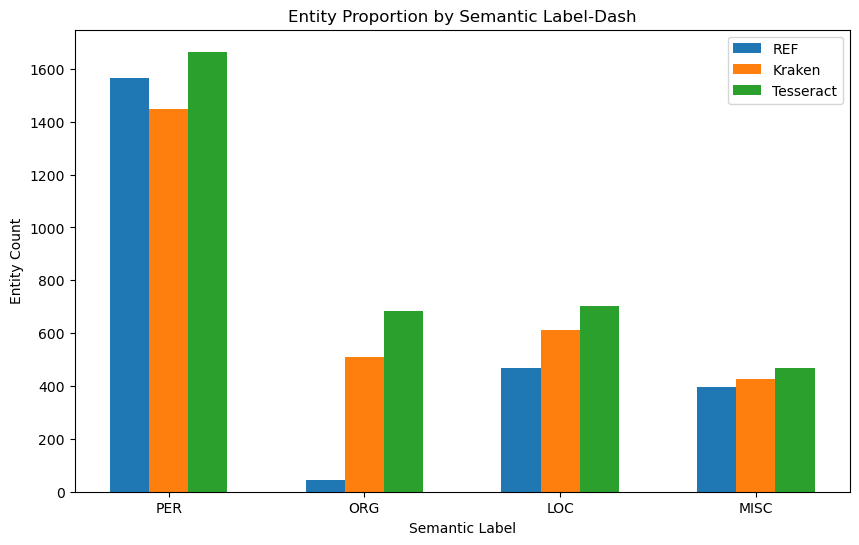

In [4]:
# visualisation  Entity Proportion by Semantic Label

#Dessiner les proportions d'entités pour chaque étiquette sémantique (PER, ORG, LOC, MISC) dans différentes versions du texte

# Définir les étiquettes sémantiques
#dash
labels = ['PER', 'ORG', 'LOC', 'MISC']
dash_ref_label_counts = {label: sum(1 for entity in ref_entities if entity['label'] == label) for label in labels}
dash_kraken_label_counts = {label: sum(1 for entity in kraken_entities if entity['label'] == label) for label in labels}
dash_tesseract_label_counts = {label: sum(1 for entity in tesseract_entities if entity['label'] == label) for label in labels}

# Dessiner un diagramme à barres
x = range(len(labels))
plt.figure(figsize=(10, 6))
plt.bar(x, dash_ref_label_counts.values(), width=0.2, align='center', label='REF')
plt.bar([i + 0.2 for i in x], dash_kraken_label_counts.values(), width=0.2, align='center', label='Kraken')
plt.bar([i + 0.4 for i in x], dash_tesseract_label_counts.values(), width=0.2, align='center', label='Tesseract')
plt.xlabel('Semantic Label')
plt.ylabel('Entity Count')
plt.xticks([i + 0.2 for i in x], labels)
plt.title('Entity Proportion by Semantic Label-Dash')
plt.legend()
plt.show()


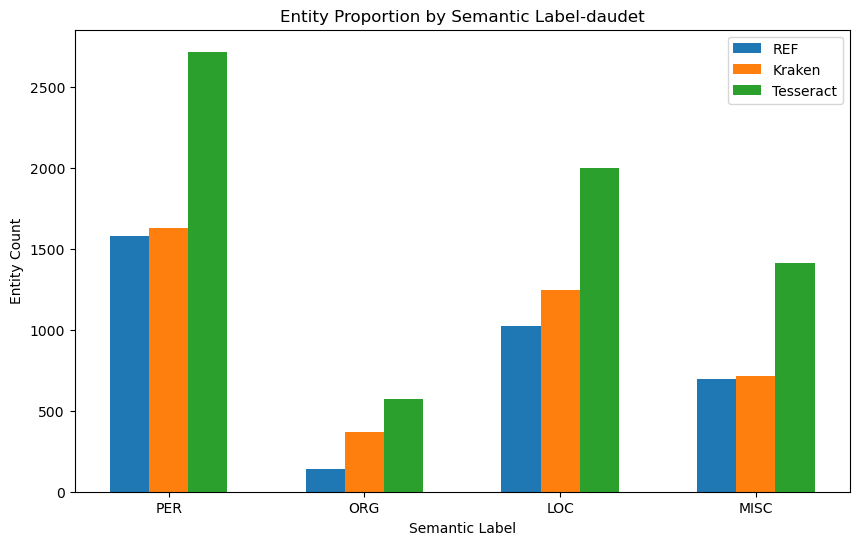

In [5]:
#daudet
labels = ['PER', 'ORG', 'LOC', 'MISC']
daudet_ref_label_counts = {label: sum(1 for entity in daudet_ref_entities if entity['label'] == label) for label in labels}
daudet_kraken_label_counts = {label: sum(1 for entity in daudet_kraken_entities if entity['label'] == label) for label in labels}
daudet_tesseract_label_counts = {label: sum(1 for entity in daudet_tesseract_entities if entity['label'] == label) for label in labels}

x = range(len(labels))
plt.figure(figsize=(10, 6))
plt.bar(x, daudet_ref_label_counts.values(), width=0.2, align='center', label='REF')
plt.bar([i + 0.2 for i in x], daudet_kraken_label_counts.values(), width=0.2, align='center', label='Kraken')
plt.bar([i + 0.4 for i in x], daudet_tesseract_label_counts.values(), width=0.2, align='center', label='Tesseract')
plt.xlabel('Semantic Label')
plt.ylabel('Entity Count')
plt.xticks([i + 0.2 for i in x], labels)
plt.title('Entity Proportion by Semantic Label-daudet')
plt.legend()
plt.show()


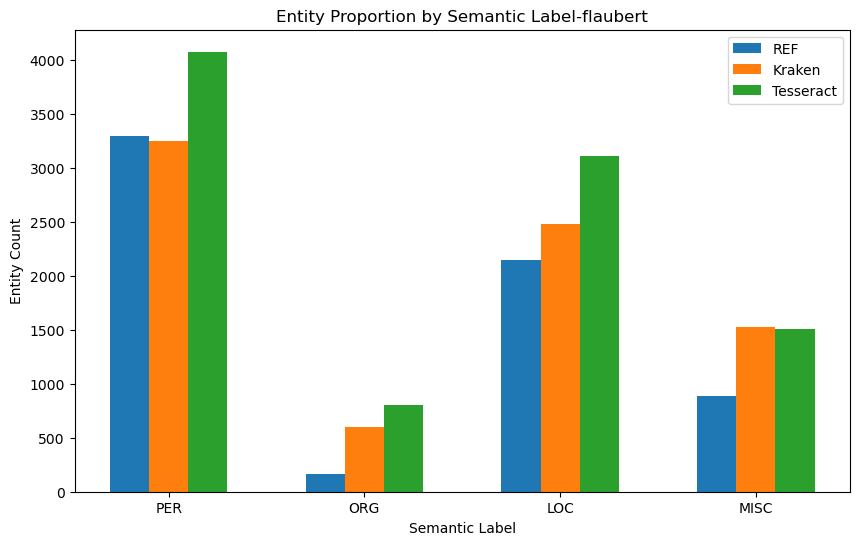

In [6]:
#flaubert
labels = ['PER', 'ORG', 'LOC', 'MISC']
flaubert_ref_label_counts = {label: sum(1 for entity in flaubert_ref_entities if entity['label'] == label) for label in labels}
flaubert_kraken_label_counts = {label: sum(1 for entity in flaubert_kraken_entities if entity['label'] == label) for label in labels}
flaubert_tesseract_label_counts = {label: sum(1 for entity in flaubert_tesseract_entities if entity['label'] == label) for label in labels}


x = range(len(labels))
plt.figure(figsize=(10, 6))
plt.bar(x, flaubert_ref_label_counts.values(), width=0.2, align='center', label='REF')
plt.bar([i + 0.2 for i in x], flaubert_kraken_label_counts.values(), width=0.2, align='center', label='Kraken')
plt.bar([i + 0.4 for i in x], flaubert_tesseract_label_counts.values(), width=0.2, align='center', label='Tesseract')
plt.xlabel('Semantic Label')
plt.ylabel('Entity Count')
plt.xticks([i + 0.2 for i in x], labels)
plt.title('Entity Proportion by Semantic Label-flaubert')
plt.legend()
plt.show()


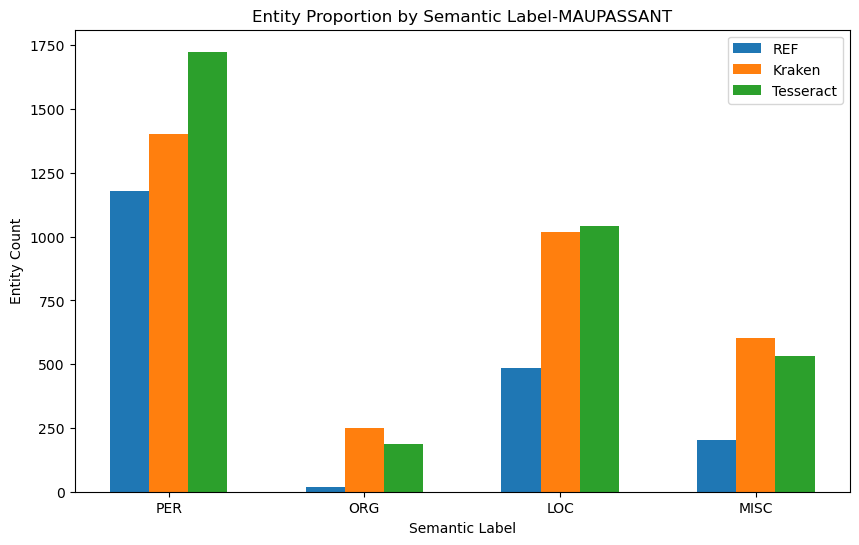

In [7]:
#maupassant
labels = ['PER', 'ORG', 'LOC', 'MISC']
MAUPASSANT_ref_label_counts = {label: sum(1 for entity in MAUPASSANT_ref_entities if entity['label'] == label) for label in labels}
MAUPASSANT_kraken_label_counts = {label: sum(1 for entity in MAUPASSANT_kraken_entities if entity['label'] == label) for label in labels}
MAUPASSANT_tesseract_label_counts = {label: sum(1 for entity in MAUPASSANT_tesseract_entities if entity['label'] == label) for label in labels}


x = range(len(labels))
plt.figure(figsize=(10, 6))
plt.bar(x, MAUPASSANT_ref_label_counts.values(), width=0.2, align='center', label='REF')
plt.bar([i + 0.2 for i in x], MAUPASSANT_kraken_label_counts.values(), width=0.2, align='center', label='Kraken')
plt.bar([i + 0.4 for i in x], MAUPASSANT_tesseract_label_counts.values(), width=0.2, align='center', label='Tesseract')
plt.xlabel('Semantic Label')
plt.ylabel('Entity Count')
plt.xticks([i + 0.2 for i in x], labels)
plt.title('Entity Proportion by Semantic Label-MAUPASSANT')
plt.legend()
plt.show()


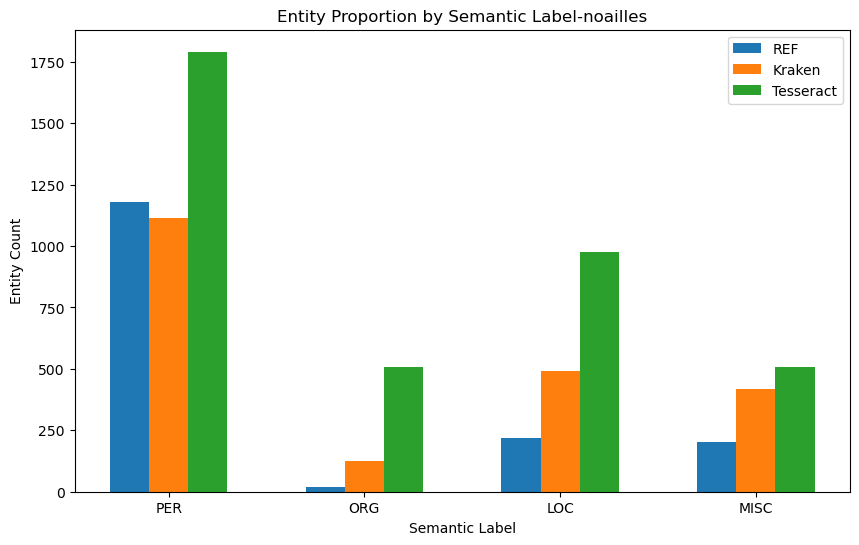

In [8]:
#noailles
labels = ['PER', 'ORG', 'LOC', 'MISC']
NOAILLES_ref_label_counts = {label: sum(1 for entity in NOAILLES_ref_entities if entity['label'] == label) for label in labels}
NOAILLES_kraken_label_counts = {label: sum(1 for entity in NOAILLES_kraken_entities if entity['label'] == label) for label in labels}
NOAILLES_tesseract_label_counts = {label: sum(1 for entity in NOAILLES_tesseract_entities if entity['label'] == label) for label in labels}

x = range(len(labels))
plt.figure(figsize=(10, 6))
plt.bar(x, NOAILLES_ref_label_counts.values(), width=0.2, align='center', label='REF')
plt.bar([i + 0.2 for i in x], NOAILLES_kraken_label_counts.values(), width=0.2, align='center', label='Kraken')
plt.bar([i + 0.4 for i in x], NOAILLES_tesseract_label_counts.values(), width=0.2, align='center', label='Tesseract')
plt.xlabel('Semantic Label')
plt.ylabel('Entity Count')
plt.xticks([i + 0.2 for i in x], labels)
plt.title('Entity Proportion by Semantic Label-noailles')
plt.legend()
plt.show()

In [9]:
#step 2 et 3 
#dash
# # Lire les résultats des entités nommées des versions de référence et OCR
with open("ref_named_entities.json", "r", encoding="utf-8") as ref_file:
    ref_entities = json.load(ref_file)

with open("kraken_named_entities.json", "r", encoding="utf-8") as kraken_file:
    kraken_entities = json.load(kraken_file)

with open("tesseract_named_entities.json", "r", encoding="utf-8") as tesseract_file:
    tesseract_entities = json.load(tesseract_file)

# Comparer les entités entre la version de référence et la version Kraken OCR
kraken_tp, kraken_fp, kraken_fn = compare_entities(ref_entities, kraken_entities)

# Comparer les entités entre la version de référence et la version Tesseract OCR
tesseract_tp, tesseract_fp, tesseract_fn = compare_entities(ref_entities, tesseract_entities)

# Calculer la précision, le rappel et le score F1
kraken_precision, kraken_recall, kraken_f1_score = calculate_metrics(kraken_tp, kraken_fp, kraken_fn)
tesseract_precision, tesseract_recall, tesseract_f1_score = calculate_metrics(tesseract_tp, tesseract_fp, tesseract_fn)

# Afficher les résultats
print("Métriques d'évaluation pour la version dash-Kraken OCR：")
print("Precision:", kraken_precision)
print("Recall:", kraken_recall)
print("F1 Score:", kraken_f1_score)
print("\nMétriques d'évaluation pour la version dash-Tesseract OCR：")
print("Precision:", tesseract_precision)
print("Recall:", tesseract_recall)
print("F1 Score:", tesseract_f1_score)


#daudet

with open("daudet_ref_named_entities.json", "r", encoding="utf-8") as daudet_ref_file:
    daudet_ref_entities = json.load(daudet_ref_file)

with open("daudet_kraken_named_entities.json", "r", encoding="utf-8") as daudet_kraken_file:
    daudet_kraken_entities = json.load(daudet_kraken_file)

with open("daudet_tesseract_named_entities.json", "r", encoding="utf-8") as daudet_tesseract_file:
    daudet_tesseract_entities = json.load(daudet_tesseract_file)


daudet_kraken_tp, daudet_kraken_fp, daudet_kraken_fn = compare_entities(daudet_ref_entities, daudet_kraken_entities)


daudet_tesseract_tp, daudet_tesseract_fp, daudet_tesseract_fn = compare_entities(daudet_ref_entities, daudet_tesseract_entities)


daudet_kraken_precision, daudet_kraken_recall, daudet_kraken_f1_score = calculate_metrics(daudet_kraken_tp, daudet_kraken_fp, daudet_kraken_fn)
daudet_tesseract_precision, daudet_tesseract_recall, daudet_tesseract_f1_score = calculate_metrics(daudet_tesseract_tp, daudet_tesseract_fp, daudet_tesseract_fn)


print("\nMétriques d'évaluation pour la version daudet kraken ocr:")
print("Precision:", daudet_kraken_precision)
print("Recall:", daudet_kraken_recall)
print("F1 Score:", daudet_kraken_f1_score)
print("\nMétriques d'évaluation pour la version daudet Tesseract ocr：")
print("Precision:", daudet_tesseract_precision)
print("Recall:", daudet_tesseract_recall)
print("F1 Score:", daudet_tesseract_f1_score)



#flaubert

with open("flaubert_ref_named_entities.json", "r", encoding="utf-8") as flaubert_ref_file:
    flaubert_ref_entities = json.load(flaubert_ref_file)

with open("flaubert_kraken_named_entities.json", "r", encoding="utf-8") as flaubert_kraken_file:
    flaubert_kraken_entities = json.load(flaubert_kraken_file)

with open("flaubert_tesseract_named_entities.json", "r", encoding="utf-8") as flaubert_tesseract_file:
    flaubert_tesseract_entities = json.load(flaubert_tesseract_file)


flaubert_kraken_tp, flaubert_kraken_fp, flaubert_kraken_fn = compare_entities(flaubert_ref_entities, flaubert_kraken_entities)


flaubert_tesseract_tp, flaubert_tesseract_fp, flaubert_tesseract_fn = compare_entities(flaubert_ref_entities, flaubert_tesseract_entities)


flaubert_kraken_precision, flaubert_kraken_recall, flaubert_kraken_f1_score = calculate_metrics(flaubert_kraken_tp, daudet_kraken_fp, flaubert_kraken_fn)
flaubert_tesseract_precision, flaubert_tesseract_recall, flaubert_tesseract_f1_score = calculate_metrics(flaubert_tesseract_tp, flaubert_tesseract_fp, flaubert_tesseract_fn)


print("\nMétriques d'évaluation pour la version flaubert kraken ocr:")
print("Precision:", flaubert_kraken_precision)
print("Recall:", flaubert_kraken_recall)
print("F1 Score:", flaubert_kraken_f1_score)
print("\nMétriques d'évaluation pour la version flaubert Tesseract ocr")
print("Precision:", flaubert_tesseract_precision)
print("Recall:", flaubert_tesseract_recall)
print("F1 Score:", flaubert_tesseract_f1_score)






##MAUPASSANT

with open("MAUPASSANT_ref_named_entities.json", "r", encoding="utf-8") as MAUPASSANT_ref_file:
    MAUPASSANT_ref_entities = json.load(MAUPASSANT_ref_file)

with open("MAUPASSANT_kraken_named_entities.json", "r", encoding="utf-8") as MAUPASSANT_kraken_file:
    MAUPASSANT_kraken_entities = json.load(MAUPASSANT_kraken_file)

with open("MAUPASSANT_tesseract_named_entities.json", "r", encoding="utf-8") as MAUPASSANT_tesseract_file:
    MAUPASSANT_tesseract_entities = json.load(MAUPASSANT_tesseract_file)


MAUPASSANT_kraken_tp, MAUPASSANT_kraken_fp, MAUPASSANT_kraken_fn = compare_entities(MAUPASSANT_ref_entities, MAUPASSANT_kraken_entities)


MAUPASSANT_tesseract_tp, MAUPASSANT_tesseract_fp, MAUPASSANT_tesseract_fn = compare_entities(MAUPASSANT_ref_entities, MAUPASSANT_tesseract_entities)


MAUPASSANT_kraken_precision, MAUPASSANT_kraken_recall, MAUPASSANT_kraken_f1_score = calculate_metrics(MAUPASSANT_kraken_tp, MAUPASSANT_kraken_fp, MAUPASSANT_kraken_fn)
MAUPASSANT_tesseract_precision, MAUPASSANT_tesseract_recall, MAUPASSANT_tesseract_f1_score = calculate_metrics(MAUPASSANT_tesseract_tp, MAUPASSANT_tesseract_fp, MAUPASSANT_tesseract_fn)


print("\nMétriques d'évaluation pour la version MAUPASSANT kraken ocr：")
print("Precision:", MAUPASSANT_kraken_precision)
print("Recall:", MAUPASSANT_kraken_recall)
print("F1 Score:", MAUPASSANT_kraken_f1_score)
print("\nMétriques d'évaluation pour la version MAUPASSANT tesseract ocr：")
print("Precision:", MAUPASSANT_tesseract_precision)
print("Recall:", MAUPASSANT_tesseract_recall)
print("F1 Score:", MAUPASSANT_tesseract_f1_score)







#NOAILLES

with open("NOAILLES_ref_named_entities.json", "r", encoding="utf-8") as NOAILLES_ref_file:
    NOAILLES_ref_entities = json.load(NOAILLES_ref_file)

with open("NOAILLES_kraken_named_entities.json", "r", encoding="utf-8") as NOAILLES_kraken_file:
    NOAILLES_kraken_entities = json.load(NOAILLES_kraken_file)

with open("NOAILLES_tesseract_named_entities.json", "r", encoding="utf-8") as NOAILLES_tesseract_file:
    NOAILLES_tesseract_entities = json.load(NOAILLES_tesseract_file)


NOAILLES_kraken_tp, NOAILLES_kraken_fp, NOAILLES_kraken_fn = compare_entities(NOAILLES_ref_entities, NOAILLES_kraken_entities)


NOAILLES_tesseract_tp, NOAILLES_tesseract_fp, NOAILLES_tesseract_fn = compare_entities(NOAILLES_ref_entities, NOAILLES_tesseract_entities)


NOAILLES_kraken_precision, NOAILLES_kraken_recall, NOAILLES_kraken_f1_score = calculate_metrics(MAUPASSANT_kraken_tp, NOAILLES_kraken_fp, NOAILLES_kraken_fn)
NOAILLES_tesseract_precision, NOAILLES_tesseract_recall, NOAILLES_tesseract_f1_score = calculate_metrics(NOAILLES_tesseract_tp, NOAILLES_tesseract_fp, NOAILLES_tesseract_fn)


print("\nMétriques d'évaluation pour la version NOAILLES kraken ocr：")
print("Precision:", NOAILLES_kraken_precision)
print("Recall:", NOAILLES_kraken_recall)
print("F1 Score:", NOAILLES_kraken_f1_score)
print("\nMétriques d'évaluation pour la version NOAILLES tesseract ocr：")
print("Precision:", NOAILLES_tesseract_precision)
print("Recall:", NOAILLES_tesseract_recall)
print("F1 Score:", NOAILLES_tesseract_f1_score)




Métriques d'évaluation pour la version dash-Kraken OCR：
Precision: 0.603338898163606
Recall: 0.7312828814245245
F1 Score: 0.6611781924624954

Métriques d'évaluation pour la version dash-Tesseract OCR：
Precision: 0.6097699517182619
Recall: 0.8688789963577499
F1 Score: 0.7166221628838452

Métriques d'évaluation pour la version daudet kraken ocr:
Precision: 0.6220373171961674
Recall: 0.7184041933605125
F1 Score: 0.6667567567567567

Métriques d'évaluation pour la version daudet Tesseract ocr：
Precision: 0.41897940913160253
Recall: 0.8177052999417589
F1 Score: 0.5540647198105763

Métriques d'évaluation pour la version flaubert kraken ocr:
Precision: 0.7253572737266398
Recall: 0.6095458044649731
F1 Score: 0.6624278423826655

Métriques d'évaluation pour la version flaubert Tesseract ocr
Precision: 0.6253687315634219
Recall: 0.9139337952270977
F1 Score: 0.7426033652342527

Métriques d'évaluation pour la version MAUPASSANT kraken ocr：
Precision: 0.46001221001221
Recall: 0.7998938428874734
F1 Sc

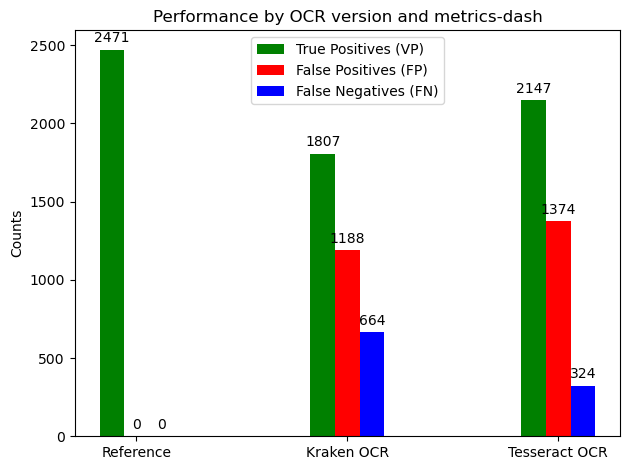

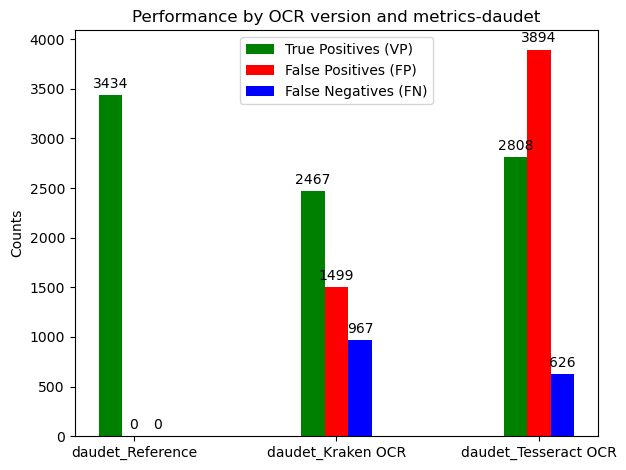

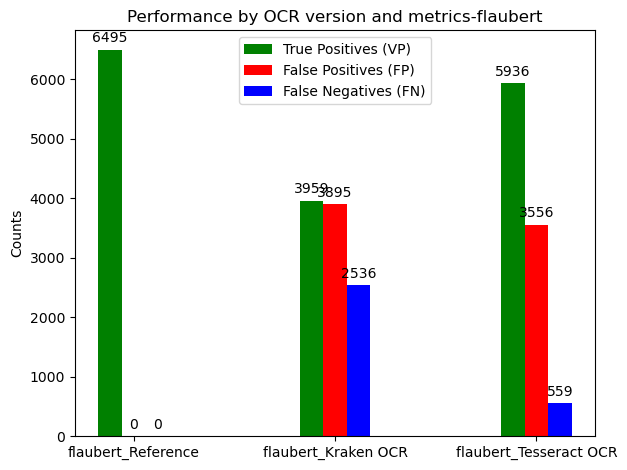

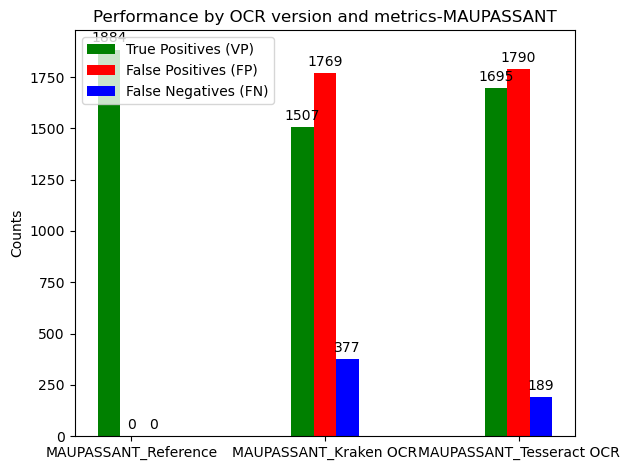

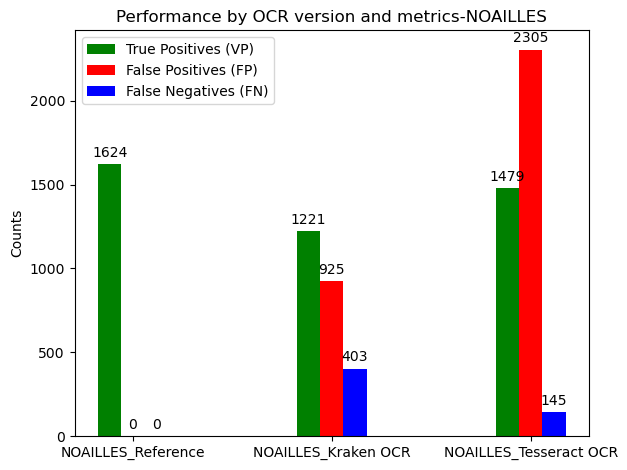

In [10]:
# visualisation Performance by OCR version and metrics'
#dash
data = {
    'Reference': {'TP': len(ref_entities), 'FP': 0, 'FN': 0}, # Dans le texte de référence, FP et FN sont à 0 car il ne se compare pas à lui-même
    'Kraken OCR': {'TP': kraken_tp, 'FP': kraken_fp, 'FN': kraken_fn},
    'Tesseract OCR': {'TP': tesseract_tp, 'FP': tesseract_fp, 'FN': tesseract_fn}
}

labels = list(data.keys())
tp = [v['TP'] for v in data.values()]
fp = [v['FP'] for v in data.values()]
fn = [v['FN'] for v in data.values()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/3, tp, width/3, label='True Positives (VP)', color='g')
rects2 = ax.bar(x, fp, width/3, label='False Positives (FP)', color='r')
rects3 = ax.bar(x + width/3, fn, width/3, label='False Negatives (FN)', color='b')

# Ajouter des étiquettes de texte, un titre et des étiquettes personnalisées aux positions de l'axe des x
ax.set_ylabel('Counts')
ax.set_title('Performance by OCR version and metrics-dash')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


# Ajouter des étiquettes sur les barres
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()




#dash
data = {
    'daudet_Reference': {'TP': len(daudet_ref_entities), 'FP': 0, 'FN': 0},  
    'daudet_Kraken OCR': {'TP': daudet_kraken_tp, 'FP': daudet_kraken_fp, 'FN': daudet_kraken_fn},
    'daudet_Tesseract OCR': {'TP': daudet_tesseract_tp, 'FP': daudet_tesseract_fp, 'FN': daudet_tesseract_fn}
}

labels = list(data.keys())
tp = [v['TP'] for v in data.values()]
fp = [v['FP'] for v in data.values()]
fn = [v['FN'] for v in data.values()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/3, tp, width/3, label='True Positives (VP)', color='g')
rects2 = ax.bar(x, fp, width/3, label='False Positives (FP)', color='r')
rects3 = ax.bar(x + width/3, fn, width/3, label='False Negatives (FN)', color='b')


ax.set_ylabel('Counts')
ax.set_title('Performance by OCR version and metrics-daudet')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()



autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()



#flaubert
data = {
    'flaubert_Reference': {'TP': len(flaubert_ref_entities), 'FP': 0, 'FN': 0},  # 参考文本不与自身比较，FP 和 FN 为0
    'flaubert_Kraken OCR': {'TP': flaubert_kraken_tp, 'FP': flaubert_kraken_fp, 'FN': flaubert_kraken_fn},
    'flaubert_Tesseract OCR': {'TP': flaubert_tesseract_tp, 'FP': flaubert_tesseract_fp, 'FN': flaubert_tesseract_fn}
}

labels = list(data.keys())
tp = [v['TP'] for v in data.values()]
fp = [v['FP'] for v in data.values()]
fn = [v['FN'] for v in data.values()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/3, tp, width/3, label='True Positives (VP)', color='g')
rects2 = ax.bar(x, fp, width/3, label='False Positives (FP)', color='r')
rects3 = ax.bar(x + width/3, fn, width/3, label='False Negatives (FN)', color='b')


ax.set_ylabel('Counts')
ax.set_title('Performance by OCR version and metrics-flaubert')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()



autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()




#MAUPASSANT
data = {
    'MAUPASSANT_Reference': {'TP': len(MAUPASSANT_ref_entities), 'FP': 0, 'FN': 0},  # 参考文本不与自身比较，FP 和 FN 为0
    'MAUPASSANT_Kraken OCR': {'TP': MAUPASSANT_kraken_tp, 'FP': MAUPASSANT_kraken_fp, 'FN': MAUPASSANT_kraken_fn},
    'MAUPASSANT_Tesseract OCR': {'TP': MAUPASSANT_tesseract_tp, 'FP': MAUPASSANT_tesseract_fp, 'FN': MAUPASSANT_tesseract_fn}
}

labels = list(data.keys())
tp = [v['TP'] for v in data.values()]
fp = [v['FP'] for v in data.values()]
fn = [v['FN'] for v in data.values()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/3, tp, width/3, label='True Positives (VP)', color='g')
rects2 = ax.bar(x, fp, width/3, label='False Positives (FP)', color='r')
rects3 = ax.bar(x + width/3, fn, width/3, label='False Negatives (FN)', color='b')


ax.set_ylabel('Counts')
ax.set_title('Performance by OCR version and metrics-MAUPASSANT')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()





#NOAILLES
data = {
    'NOAILLES_Reference': {'TP': len(NOAILLES_ref_entities), 'FP': 0, 'FN': 0},  
    'NOAILLES_Kraken OCR': {'TP': NOAILLES_kraken_tp, 'FP': NOAILLES_kraken_fp, 'FN': NOAILLES_kraken_fn},
    'NOAILLES_Tesseract OCR': {'TP': NOAILLES_tesseract_tp, 'FP': NOAILLES_tesseract_fp, 'FN': NOAILLES_tesseract_fn}
}

labels = list(data.keys())
tp = [v['TP'] for v in data.values()]
fp = [v['FP'] for v in data.values()]
fn = [v['FN'] for v in data.values()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/3, tp, width/3, label='True Positives (VP)', color='g')
rects2 = ax.bar(x, fp, width/3, label='False Positives (FP)', color='r')
rects3 = ax.bar(x + width/3, fn, width/3, label='False Negatives (FN)', color='b')


ax.set_ylabel('Counts')
ax.set_title('Performance by OCR version and metrics-NOAILLES')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()



autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()


In [11]:
#step4
# Annoter le fichier texte de la version de référence avec les étiquettes de parties du discours et sauvegarder les résultats dans un fichier de sortie
annotate_pos("DATA-ELTeC/DASH/REF/DASH_chateau-de-Pinon-V1_PP.txt", "ref_pos_tags.txt")

# Annoter le fichier texte de la version OCR Kraken avec les étiquettes de parties du discours et sauvegarder les résultats dans un fichier de sortie
annotate_pos("DATA-ELTeC/DASH/DASH_kraken/DASH_chateau-de-Pinon-V1_Kraken-base.txt", "kraken_pos_tags.txt")

# Annoter le fichier texte de la version OCR Tesseract avec les étiquettes de parties du discours et sauvegarder les résultats dans un fichier de sortie
annotate_pos("DATA-ELTeC/DASH/DASH_TesseractFra-PNG/DASH_chateau-de-Pinon-V1_TesseractFra-PNG.txt", "tesseract_pos_tags.txt")








annotate_pos("DATA-ELTeC/DAUDET/REF/DAUDET_petit-chose_PP.txt", "DAUDET_ref_pos_tags.txt")


annotate_pos("DATA-ELTeC/DAUDET/DAUDET_kraken/DAUDET_petit-chose_Kraken-base.txt", "DAUDET_kraken_pos_tags.txt")


annotate_pos("DATA-ELTeC/DAUDET/DAUDET_TesseractFra-PNG/DAUDET_petit-chose_TesseractFra-PNG.txt", "DAUDET_tesseract_pos_tags.txt")







annotate_pos("DATA-ELTeC/FLAUBERT/REF/FLAUBERT_education-sentimentale_PP.txt", "FLAUBERT_ref_pos_tags.txt")


annotate_pos("DATA-ELTeC/FLAUBERT/FLAUBERT_kraken/FLAUBERT_education-sentimentale_Kraken-base.txt", "FLAUBERT_kraken_pos_tags.txt")


annotate_pos("DATA-ELTeC/FLAUBERT/FLAUBERT_TesseractFra-PNG/FLAUBERT_education-sentimentale_TesseractFra-PNG.txt", "FLAUBERT_tesseract_pos_tags.txt")







#MAUPASSANT

annotate_pos("DATA-ELTeC/MAUPASSANT/REF/MAUPASSANT_une-vie_PP.txt", "MAUPASSANT_ref_pos_tags.txt")


annotate_pos("DATA-ELTeC/MAUPASSANT/MAUPASSANT_kraken/MAUPASSANT_une-vie_Kraken-base.txt", "MAUPASSANT_kraken_pos_tags.txt")


annotate_pos("DATA-ELTeC/MAUPASSANT/MAUPASSANT_TesseractFra-PNG/MAUPASSANT_une-vie_TesseractFra-PNG.txt", "MAUPASSANT_tesseract_pos_tags.txt")





#NOAILLES

annotate_pos("DATA-ELTeC/NOAILLES/REF/NOAILLES_la-nouvelle-esperance_PP.txt", "NOAILLES_ref_pos_tags.txt")


annotate_pos("DATA-ELTeC/NOAILLES/NOAILLES_kraken/NOAILLES_la-nouvelle-esperance_Kraken-base.txt", "NOAILLES_kraken_pos_tags.txt")


annotate_pos("DATA-ELTeC/NOAILLES/NOAILLES_TesseractFra-PNG/NOAILLES_la-nouvelle-esperance_TesseractFra-PNG.txt", "NOAILLES_tesseract_pos_tags.txt")

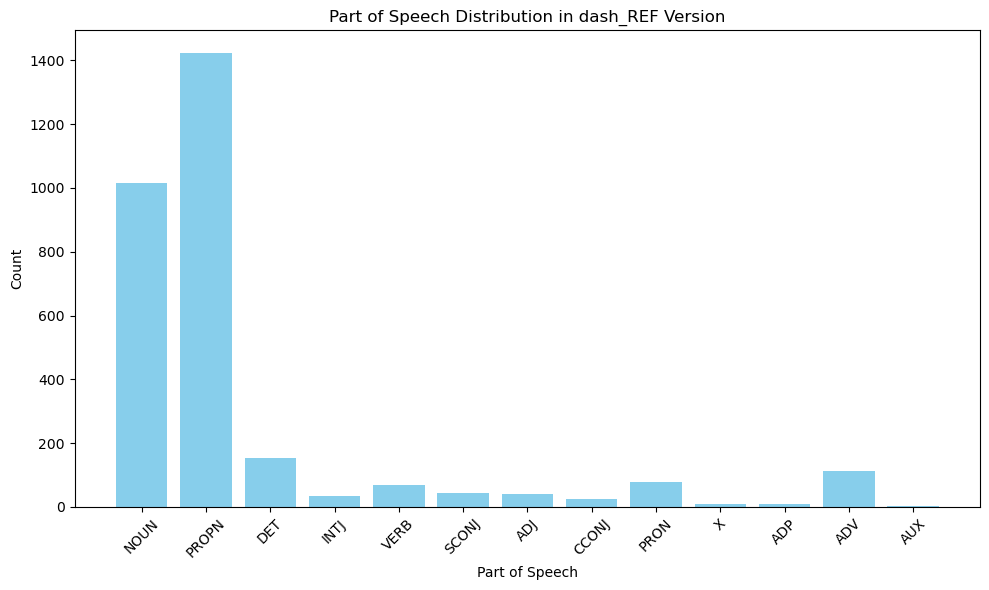

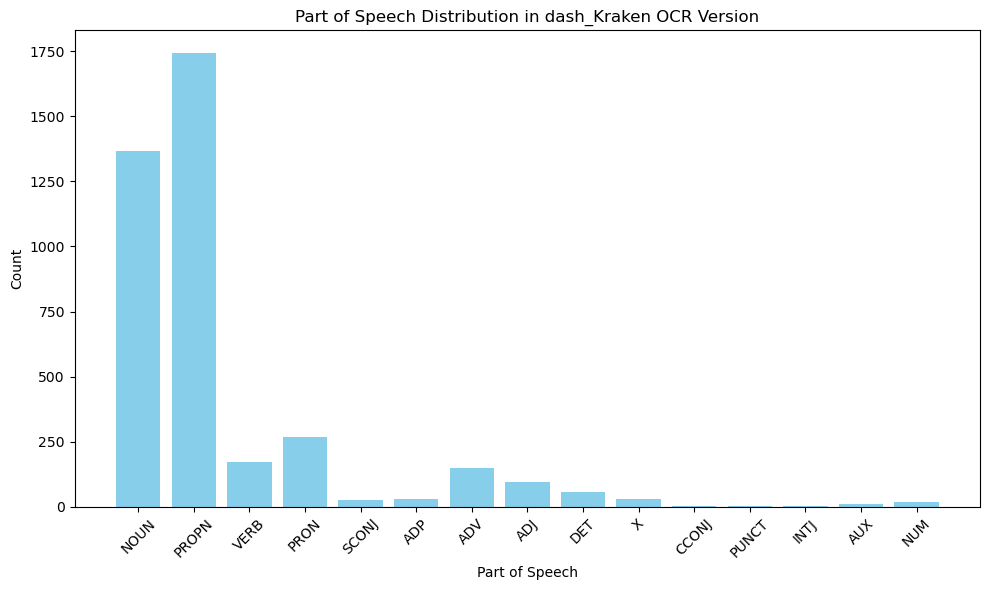

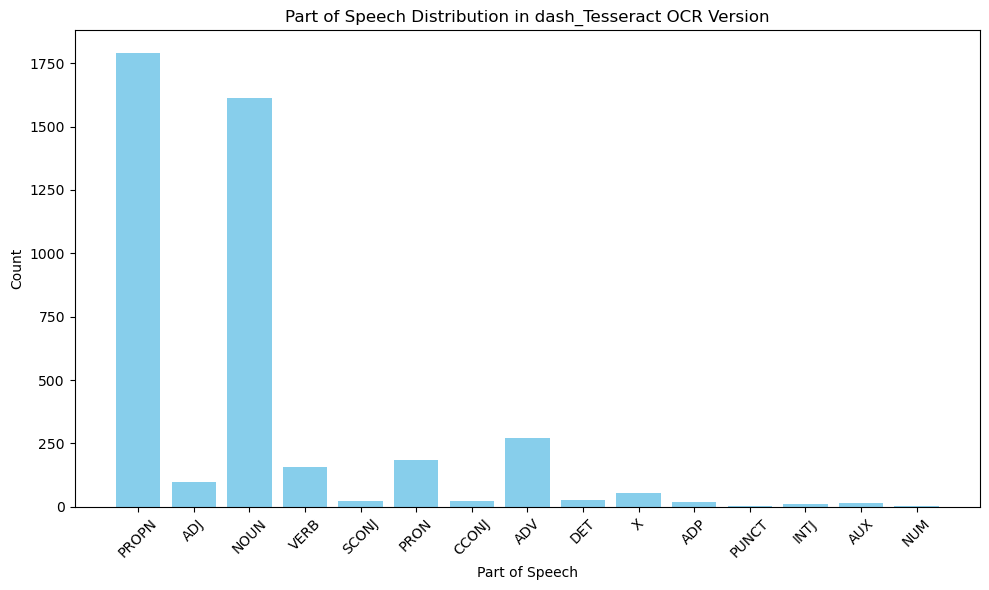

In [12]:
# Charger les données des entités nommées
ref_entities = load_named_entities("ref_named_entities.json")
kraken_entities = load_named_entities("kraken_named_entities.json")
tesseract_entities = load_named_entities("tesseract_named_entities.json")


# Statistiques et représentation graphique de la distribution des parties du discours pour chaque version
ref_pos_counts = count_pos_in_entities("ref_pos_tags.txt", ref_entities)
kraken_pos_counts = count_pos_in_entities("kraken_pos_tags.txt", kraken_entities)
tesseract_pos_counts = count_pos_in_entities("tesseract_pos_tags.txt", tesseract_entities)



plot_pos_counts(ref_pos_counts, 'Part of Speech Distribution in dash_REF Version')
plot_pos_counts(kraken_pos_counts, 'Part of Speech Distribution in dash_Kraken OCR Version')
plot_pos_counts(tesseract_pos_counts, 'Part of Speech Distribution in dash_Tesseract OCR Version')



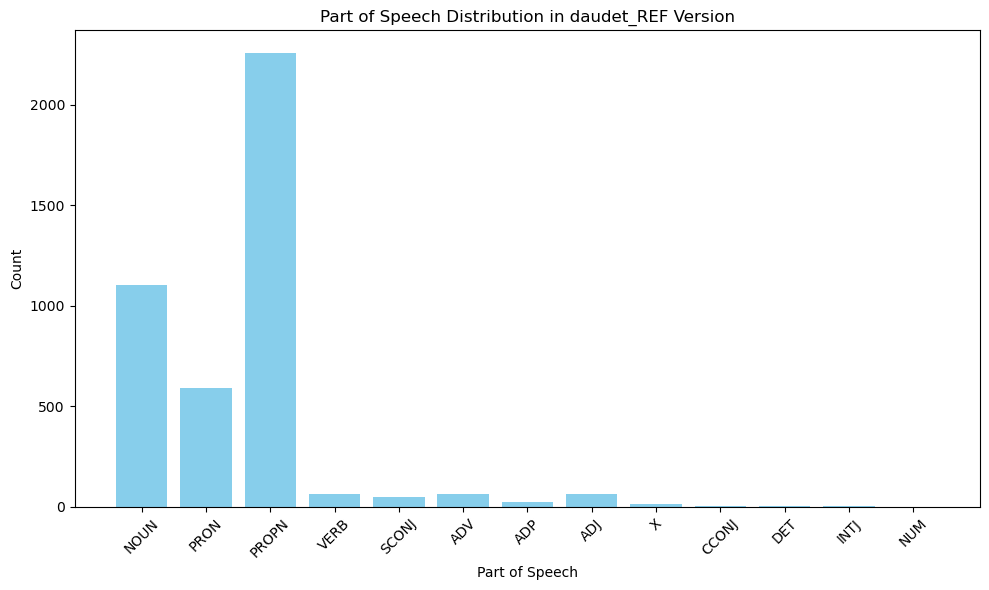

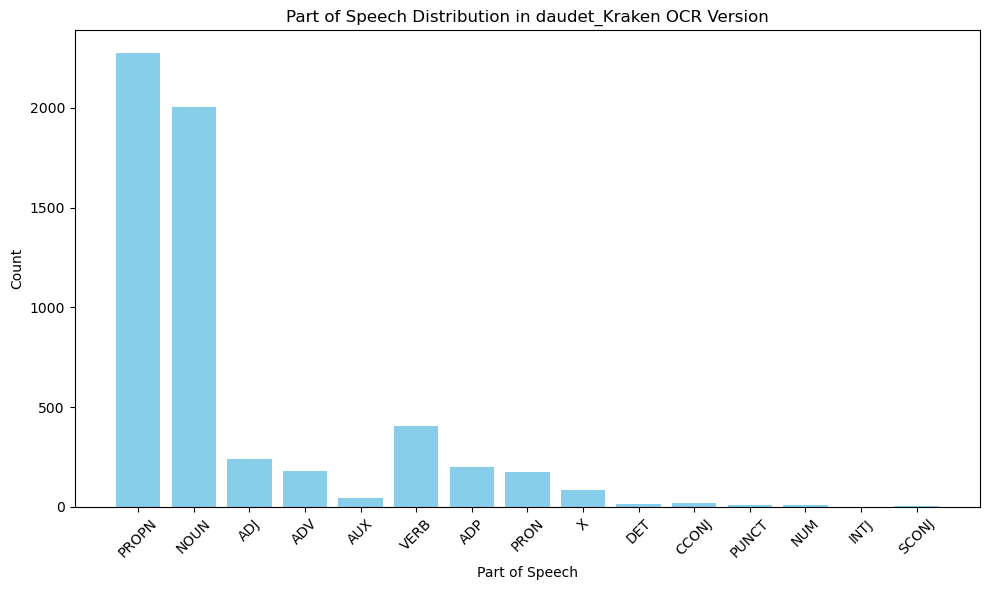

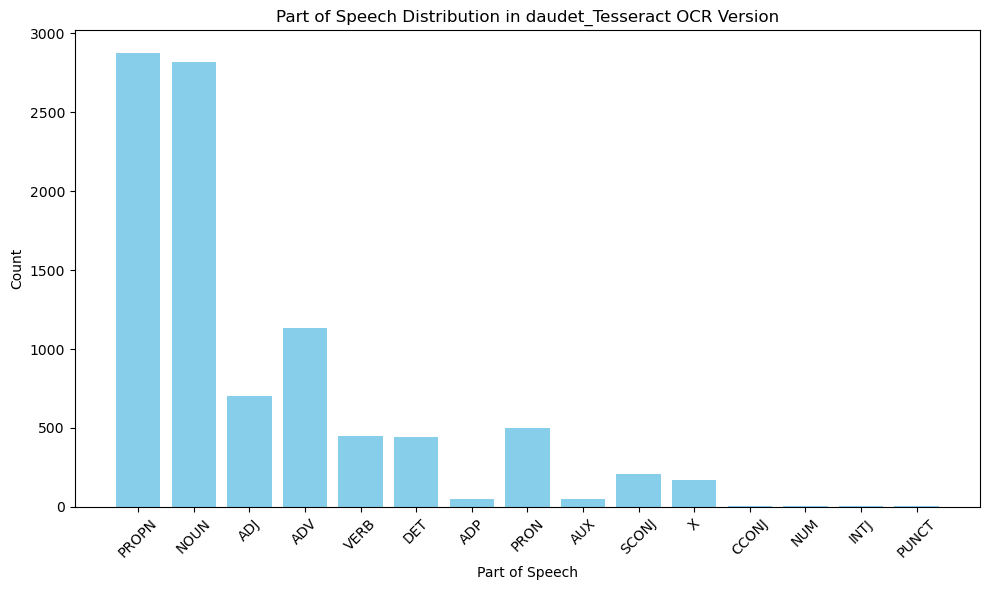

In [13]:
daudet_ref_entities = load_named_entities("daudet_ref_named_entities.json")
daudet_kraken_entities = load_named_entities("daudet_kraken_named_entities.json")
daudet_tesseract_entities = load_named_entities("daudet_tesseract_named_entities.json")


daudet_ref_pos_counts = count_pos_in_entities("DAUDET_ref_pos_tags.txt", daudet_ref_entities)
daudet_kraken_pos_counts = count_pos_in_entities("DAUDET_kraken_pos_tags.txt", daudet_kraken_entities)
daudet_tesseract_pos_counts = count_pos_in_entities("DAUDET_tesseract_pos_tags.txt", daudet_tesseract_entities)


plot_pos_counts(daudet_ref_pos_counts, 'Part of Speech Distribution in daudet_REF Version')
plot_pos_counts(daudet_kraken_pos_counts, 'Part of Speech Distribution in daudet_Kraken OCR Version')
plot_pos_counts(daudet_tesseract_pos_counts, 'Part of Speech Distribution in daudet_Tesseract OCR Version')


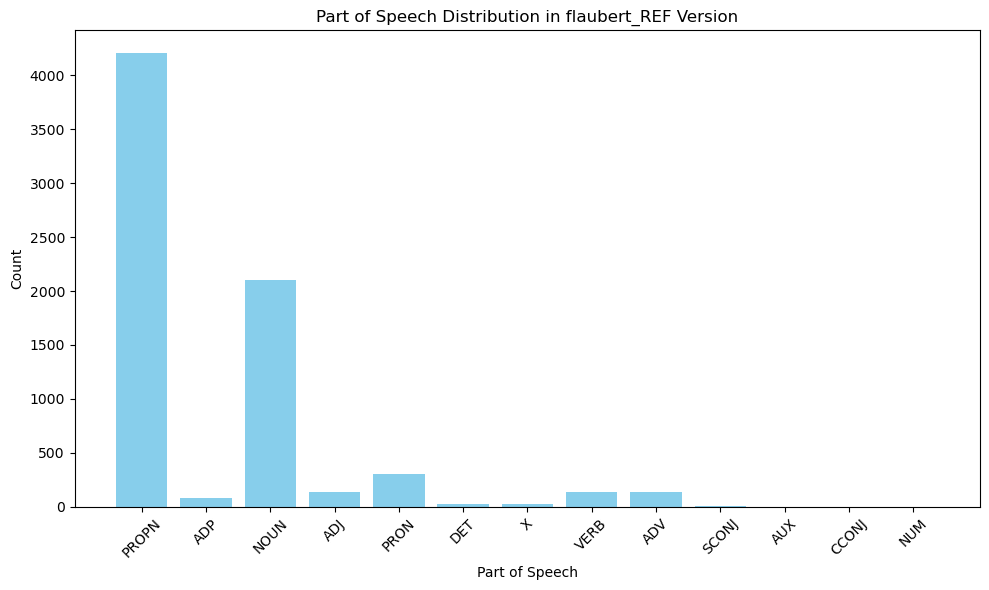

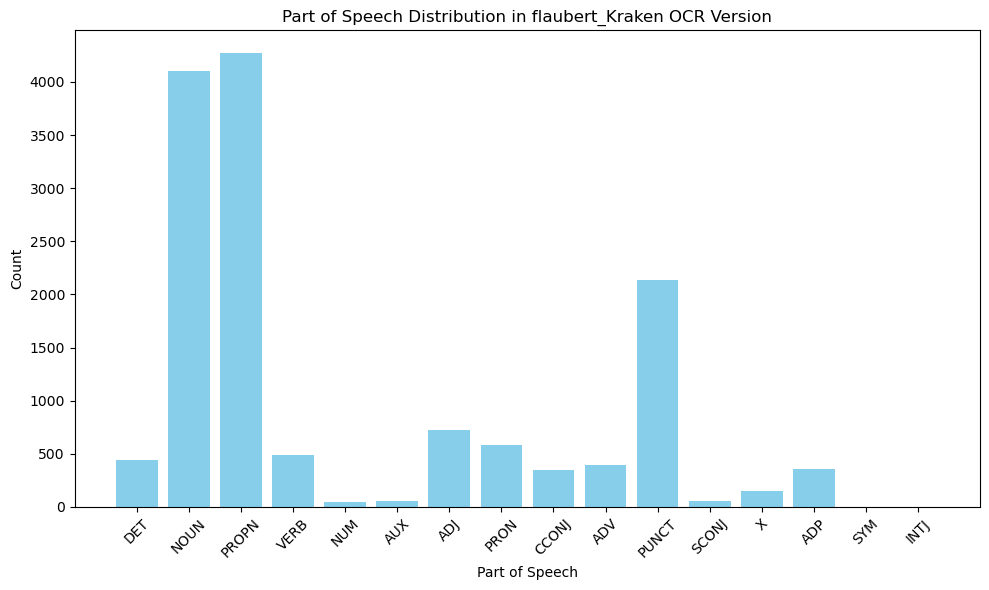

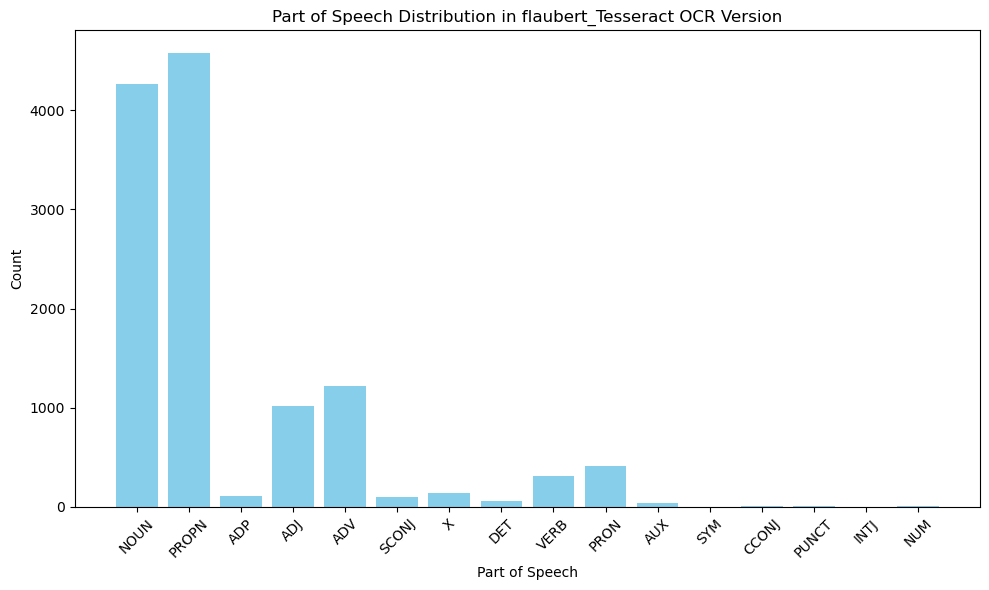

In [14]:
flaubert_ref_entities = load_named_entities("flaubert_ref_named_entities.json")
flaubert_kraken_entities = load_named_entities("flaubert_kraken_named_entities.json")
flaubert_tesseract_entities = load_named_entities("flaubert_tesseract_named_entities.json")

flaubert_ref_pos_counts = count_pos_in_entities("FLAUBERT_ref_pos_tags.txt", flaubert_ref_entities)
flaubert_kraken_pos_counts = count_pos_in_entities("FLAUBERT_kraken_pos_tags.txt", flaubert_kraken_entities)
flaubert_tesseract_pos_counts = count_pos_in_entities("FLAUBERT_tesseract_pos_tags.txt", flaubert_tesseract_entities)


plot_pos_counts(flaubert_ref_pos_counts, 'Part of Speech Distribution in flaubert_REF Version')
plot_pos_counts(flaubert_kraken_pos_counts, 'Part of Speech Distribution in flaubert_Kraken OCR Version')
plot_pos_counts(flaubert_tesseract_pos_counts, 'Part of Speech Distribution in flaubert_Tesseract OCR Version')


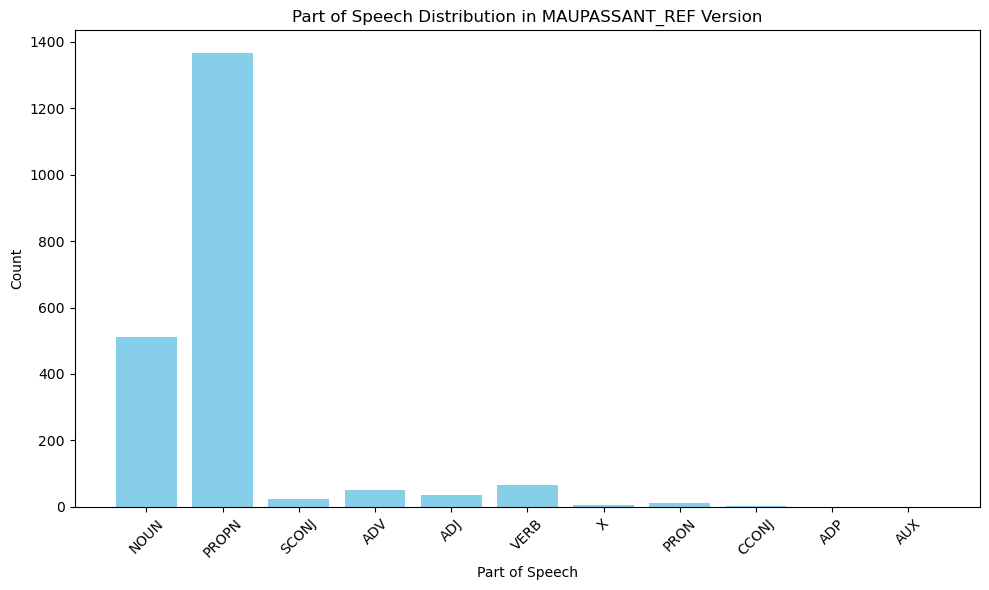

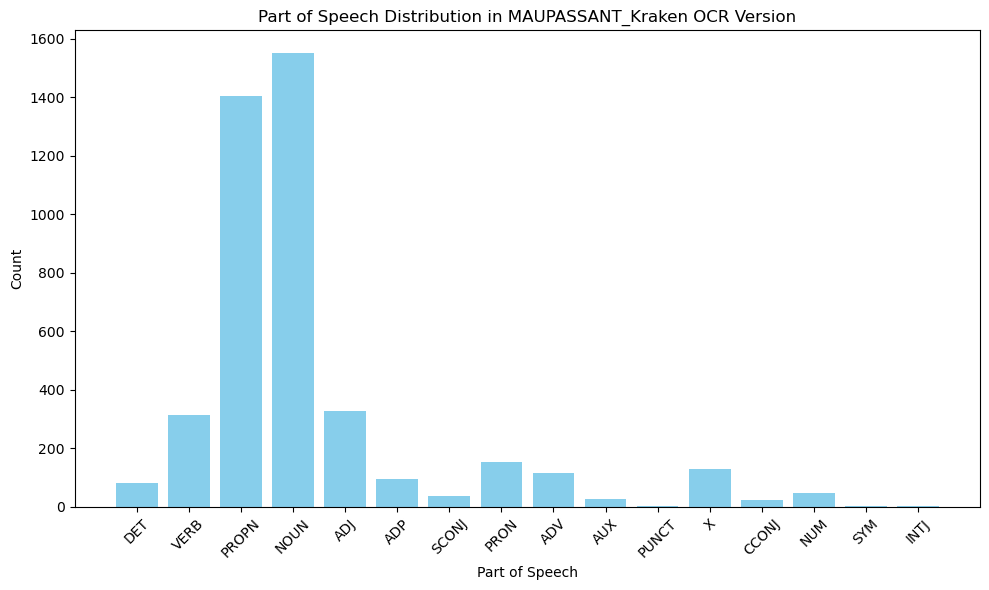

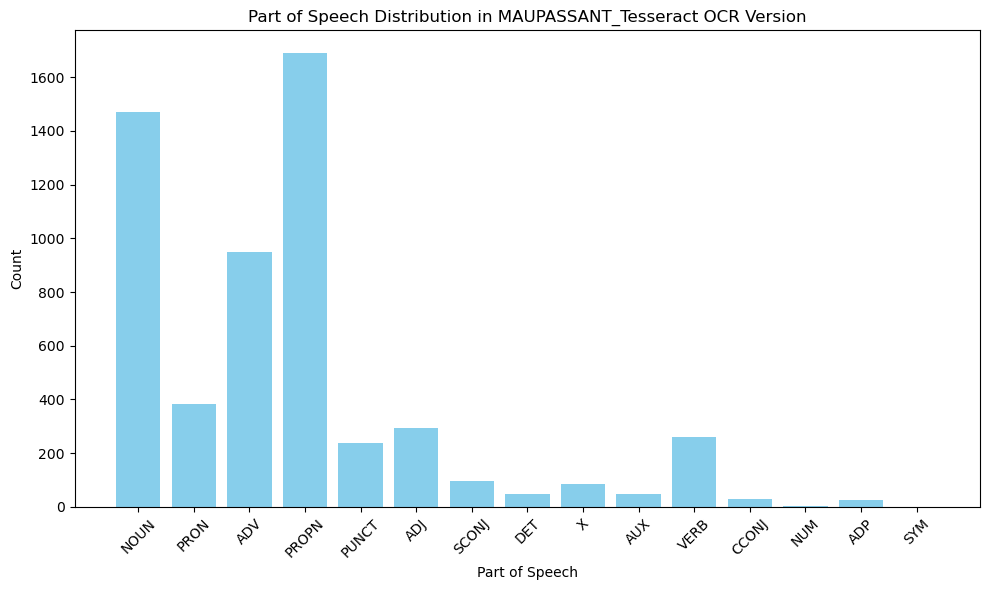

In [15]:
MAUPASSANT_ref_entities = load_named_entities("MAUPASSANT_ref_named_entities.json")
MAUPASSANT_kraken_entities = load_named_entities("MAUPASSANT_kraken_named_entities.json")
MAUPASSANT_tesseract_entities = load_named_entities("MAUPASSANT_tesseract_named_entities.json")



MAUPASSANT_ref_pos_counts = count_pos_in_entities("MAUPASSANT_ref_pos_tags.txt", MAUPASSANT_ref_entities)
MAUPASSANT_kraken_pos_counts = count_pos_in_entities("MAUPASSANT_kraken_pos_tags.txt", MAUPASSANT_kraken_entities)
MAUPASSANT_tesseract_pos_counts = count_pos_in_entities("MAUPASSANT_tesseract_pos_tags.txt", MAUPASSANT_tesseract_entities)

plot_pos_counts(MAUPASSANT_ref_pos_counts, 'Part of Speech Distribution in MAUPASSANT_REF Version')
plot_pos_counts(MAUPASSANT_kraken_pos_counts, 'Part of Speech Distribution in MAUPASSANT_Kraken OCR Version')
plot_pos_counts(MAUPASSANT_tesseract_pos_counts, 'Part of Speech Distribution in MAUPASSANT_Tesseract OCR Version')



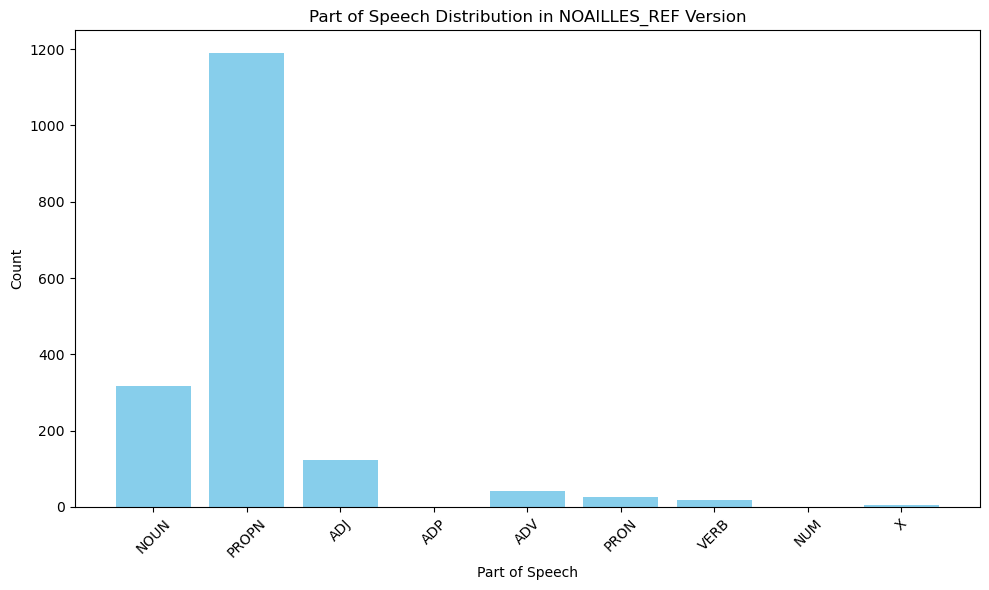

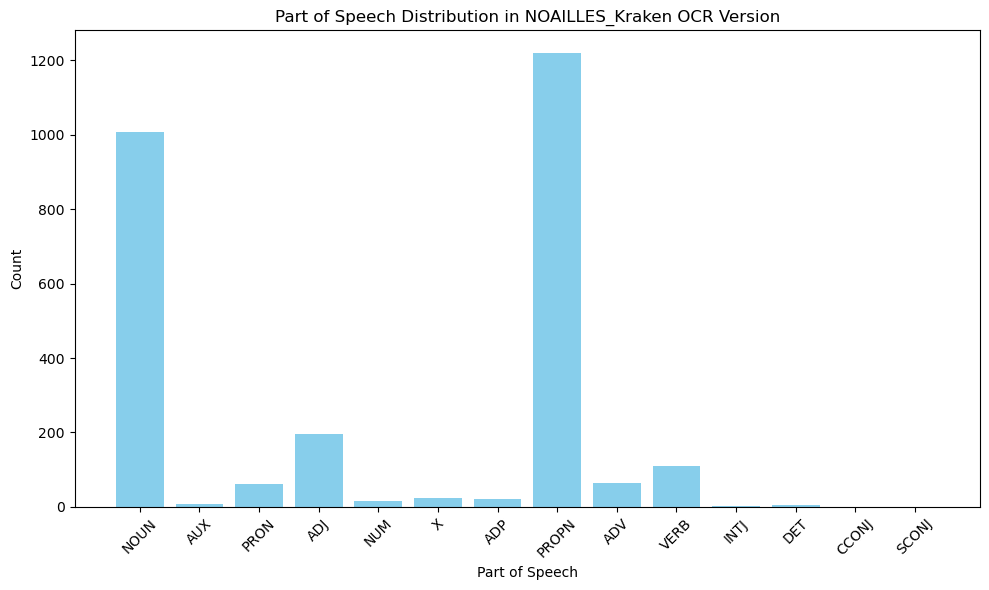

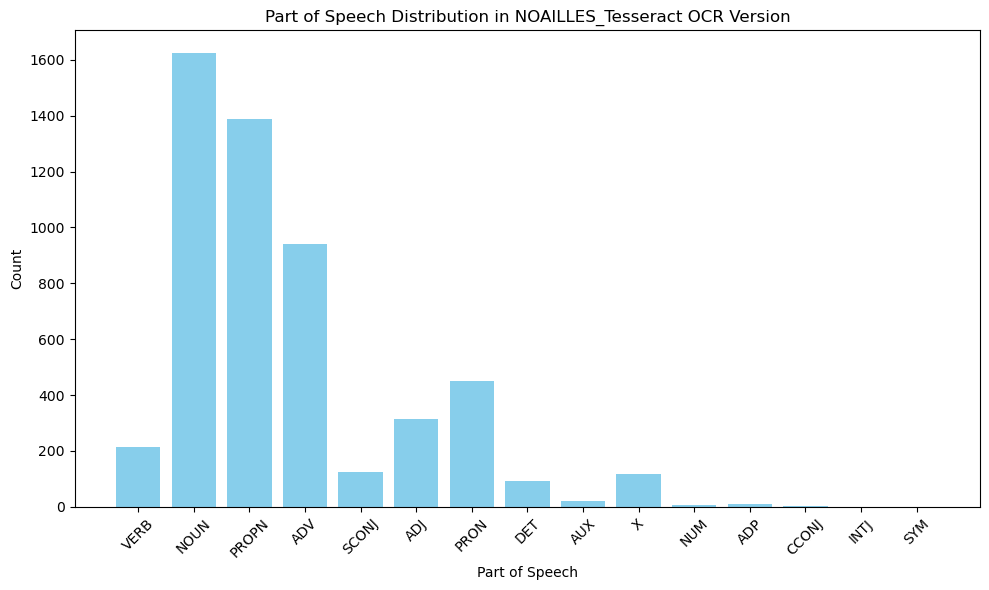

In [16]:
NOAILLES_ref_entities = load_named_entities("NOAILLES_ref_named_entities.json")
NOAILLES_kraken_entities = load_named_entities("NOAILLES_kraken_named_entities.json")
NOAILLES_tesseract_entities = load_named_entities("NOAILLES_tesseract_named_entities.json")

NOAILLES_ref_pos_counts = count_pos_in_entities("NOAILLES_ref_pos_tags.txt", NOAILLES_ref_entities)
NOAILLES_kraken_pos_counts = count_pos_in_entities("NOAILLES_kraken_pos_tags.txt", NOAILLES_kraken_entities)
NOAILLES_tesseract_pos_counts = count_pos_in_entities("NOAILLES_tesseract_pos_tags.txt", NOAILLES_tesseract_entities)


plot_pos_counts(NOAILLES_ref_pos_counts, 'Part of Speech Distribution in NOAILLES_REF Version')
plot_pos_counts(NOAILLES_kraken_pos_counts, 'Part of Speech Distribution in NOAILLES_Kraken OCR Version')
plot_pos_counts(NOAILLES_tesseract_pos_counts, 'Part of Speech Distribution in NOAILLES_Tesseract OCR Version')

In [17]:
# step 5

# Extraire les tokens "PROPN" (noms propres) des résultats de l'annotation POS de la version de référence
ref_propn_tokens = extract_propn_tokens("ref_pos_tags.txt")

# Extraire les tokens "PROPN" des résultats de l'annotation POS de la version OCR Kraken
kraken_propn_tokens = extract_propn_tokens("kraken_pos_tags.txt")

# Extraire les tokens "PROPN" des résultats de l'annotation POS de la version OCR Tesseract
tesseract_propn_tokens = extract_propn_tokens("tesseract_pos_tags.txt")





daudet_ref_propn_tokens = extract_propn_tokens("DAUDET_ref_pos_tags.txt")


daudet_kraken_propn_tokens = extract_propn_tokens("DAUDET_kraken_pos_tags.txt")


daudet_tesseract_propn_tokens = extract_propn_tokens("DAUDET_tesseract_pos_tags.txt")








FLAUBERT_ref_propn_tokens = extract_propn_tokens("FLAUBERT_ref_pos_tags.txt")


FLAUBERT_kraken_propn_tokens = extract_propn_tokens("FLAUBERT_kraken_pos_tags.txt")


FLAUBERT_tesseract_propn_tokens = extract_propn_tokens("FLAUBERT_tesseract_pos_tags.txt")








MAUPASSANT_ref_propn_tokens = extract_propn_tokens("MAUPASSANT_ref_pos_tags.txt")


MAUPASSANT_kraken_propn_tokens = extract_propn_tokens("MAUPASSANT_kraken_pos_tags.txt")


MAUPASSANT_tesseract_propn_tokens = extract_propn_tokens("MAUPASSANT_tesseract_pos_tags.txt")









NOAILLES_ref_propn_tokens = extract_propn_tokens("NOAILLES_ref_pos_tags.txt")


NOAILLES_kraken_propn_tokens = extract_propn_tokens("NOAILLES_kraken_pos_tags.txt")


NOAILLES_tesseract_propn_tokens = extract_propn_tokens("NOAILLES_tesseract_pos_tags.txt")


print("\nREF  PROPN tokens:", ref_propn_tokens)
print("\nKraken OCR  PROPN tokens:", kraken_propn_tokens)
print("\nTesseract OCR  PROPN tokens:", tesseract_propn_tokens)


print("\n daudet REF  PROPN tokens:", daudet_ref_propn_tokens)
print("\ndaudet Kraken OCR  PROPN tokens:", daudet_kraken_propn_tokens)
print("\ndaudet Tesseract OCR  PROPN tokens:", daudet_tesseract_propn_tokens)



print("\n FLAUBERT REF  PROPN tokens:", FLAUBERT_ref_propn_tokens)
print("\n FLAUBERT Kraken OCR  PROPN tokens:", FLAUBERT_kraken_propn_tokens)
print("\n FLAUBERT Tesseract OCR  PROPN tokens:", FLAUBERT_tesseract_propn_tokens)

print("\n MAUPASSANT REF  PROPN tokens:", MAUPASSANT_ref_propn_tokens)
print("\n MAUPASSANT Kraken OCR  PROPN tokens:", MAUPASSANT_kraken_propn_tokens)
print("\n MAUPASSANT Tesseract OCR  PROPN tokens:", MAUPASSANT_tesseract_propn_tokens)


print("\n NOAILLES REF  PROPN tokens:", NOAILLES_ref_propn_tokens)
print("\n NOAILLES Kraken OCR  PROPN tokens:", NOAILLES_kraken_propn_tokens)
print("\n NOAILLES Tesseract OCR  PROPN tokens:", NOAILLES_tesseract_propn_tokens)


REF  PROPN tokens: ['Saint-Honoré', 'Saint-Gabriel', 'Lameth', 'Louison', 'te', 'Paris', 'Bussy', 'Sissone', 'Bussy', '-', 'Lameth', 'Oui', 'Henriette', 'Henriette', 'Pinon', 'Lameth', 'Paris', 'interrompit', 'Bussy', '-', 'Lameth', 'gentilhomme', 'Roucy', 'Paris', 'Henriette', 'Mademoiselle', 'Roucy', 'Lameth', 'Sissone', 'Bussy', 'Bussy', 'dédain', 'Louison', 'Roucy', 'Lameth', 'Roucy', 'Louison', 'Réjouissez', 'Bussy', 'Louison', 'Eh', 'Dieu', 'Lameth', 'Paris', 'Bussy', '-', 'Lameth', 'Roucy', 'Henriette', 'Celui', 'Roucy', 'Bussy', '-', 'Lameth', 'Bussy', '-', 'Lameth', 'Lameth', 'Roucy', 'Sissone', 'Paris', 'Bussy', '-', 'Lameth', 'Sissone', 'Pinon', 'Louison', 'Beaupré', 'Louison', 'Paris', 'Roucy', 'Sissone', 'Pinon', 'Bussy', '-', 'Lameth', 'Paris', "J'", "J'", 'Louison', 'Beaupré', 'Heudicourt', 'Versailles', 'Chardu', 'Laon', 'Henriette', 'Roucy', 'Bussy', '-', 'Lameth', 'Pinon', 'Roucy', 'soyez', 'Bussy', '-', 'Lameth', 'Bon', 'Dieu', 'Louison', 'Louison', 'Roucy', 'Henrie

In [18]:
#step 6
# Extraire les tokens "PROPN" des versions de référence et OCR

ref_propn_tokens = set(ref_propn_tokens)
kraken_propn_tokens = set(kraken_propn_tokens)
tesseract_propn_tokens = set(tesseract_propn_tokens)

daudet_ref_propn_tokens = set(daudet_ref_propn_tokens)
daudet_kraken_propn_tokens = set(daudet_kraken_propn_tokens)
daudet_tesseract_propn_tokens = set(daudet_tesseract_propn_tokens)

FLAUBERT_ref_propn_tokens = set(FLAUBERT_ref_propn_tokens)
FLAUBERT_kraken_propn_tokens = set(FLAUBERT_kraken_propn_tokens)
FLAUBERT_tesseract_propn_tokens = set(FLAUBERT_tesseract_propn_tokens)


MAUPASSANT_ref_propn_tokens = set(MAUPASSANT_ref_propn_tokens)
MAUPASSANT_kraken_propn_tokens = set(MAUPASSANT_kraken_propn_tokens)
MAUPASSANT_tesseract_propn_tokens = set(MAUPASSANT_tesseract_propn_tokens)

NOAILLES_ref_propn_tokens = set(NOAILLES_ref_propn_tokens)
NOAILLES_kraken_propn_tokens = set(NOAILLES_kraken_propn_tokens)
NOAILLES_tesseract_propn_tokens = set(NOAILLES_tesseract_propn_tokens)





# 计算交集、并集和差集
intersection_kraken_ref = ref_propn_tokens.intersection(kraken_propn_tokens)
intersection_tesseract_ref = ref_propn_tokens.intersection(tesseract_propn_tokens)

union_kraken_ref = ref_propn_tokens.union(kraken_propn_tokens)
union_tesseract_ref = ref_propn_tokens.union(tesseract_propn_tokens)

difference_kraken_ref = ref_propn_tokens.difference(kraken_propn_tokens)
difference_tesseract_ref = ref_propn_tokens.difference(tesseract_propn_tokens)



daudet_intersection_kraken_ref = daudet_ref_propn_tokens.intersection(daudet_kraken_propn_tokens)
daudet_intersection_tesseract_ref = daudet_ref_propn_tokens.intersection(daudet_tesseract_propn_tokens)

daudet_union_kraken_ref = daudet_ref_propn_tokens.union(daudet_kraken_propn_tokens)
daudet_union_tesseract_ref = daudet_ref_propn_tokens.union(daudet_tesseract_propn_tokens)

daudet_difference_kraken_ref = daudet_ref_propn_tokens.difference(daudet_kraken_propn_tokens)
daudet_difference_tesseract_ref = daudet_ref_propn_tokens.difference(daudet_tesseract_propn_tokens)


FLAUBERT_intersection_kraken_ref = FLAUBERT_ref_propn_tokens.intersection(FLAUBERT_kraken_propn_tokens)
FLAUBERT_intersection_tesseract_ref = FLAUBERT_ref_propn_tokens.intersection(FLAUBERT_tesseract_propn_tokens)

FLAUBERT_union_kraken_ref = FLAUBERT_ref_propn_tokens.union(FLAUBERT_kraken_propn_tokens)
FLAUBERT_union_tesseract_ref = FLAUBERT_ref_propn_tokens.union(FLAUBERT_tesseract_propn_tokens)

FLAUBERT_difference_kraken_ref = FLAUBERT_ref_propn_tokens.difference(FLAUBERT_kraken_propn_tokens)
FLAUBERT_difference_tesseract_ref = FLAUBERT_ref_propn_tokens.difference(FLAUBERT_tesseract_propn_tokens)



MAUPASSANT_intersection_kraken_ref = MAUPASSANT_ref_propn_tokens.intersection(MAUPASSANT_kraken_propn_tokens)
MAUPASSANT_intersection_tesseract_ref = MAUPASSANT_ref_propn_tokens.intersection(MAUPASSANT_tesseract_propn_tokens)

MAUPASSANT_union_kraken_ref = MAUPASSANT_ref_propn_tokens.union(MAUPASSANT_kraken_propn_tokens)
MAUPASSANT_union_tesseract_ref = MAUPASSANT_ref_propn_tokens.union(MAUPASSANT_tesseract_propn_tokens)

MAUPASSANT_difference_kraken_ref = MAUPASSANT_ref_propn_tokens.difference(MAUPASSANT_kraken_propn_tokens)
MAUPASSANT_difference_tesseract_ref = MAUPASSANT_ref_propn_tokens.difference(MAUPASSANT_tesseract_propn_tokens)




NOAILLES_intersection_kraken_ref = NOAILLES_ref_propn_tokens.intersection(NOAILLES_kraken_propn_tokens)
NOAILLES_intersection_tesseract_ref = NOAILLES_ref_propn_tokens.intersection(NOAILLES_tesseract_propn_tokens)

NOAILLES_union_kraken_ref = NOAILLES_ref_propn_tokens.union(NOAILLES_kraken_propn_tokens)
NOAILLES_union_tesseract_ref = NOAILLES_ref_propn_tokens.union(NOAILLES_tesseract_propn_tokens)

NOAILLES_difference_kraken_ref = NOAILLES_ref_propn_tokens.difference(NOAILLES_kraken_propn_tokens)
NOAILLES_difference_tesseract_ref = NOAILLES_ref_propn_tokens.difference(NOAILLES_tesseract_propn_tokens)




















print("dash-intersection entre ref et Kraken OCR ：", intersection_kraken_ref)
print("dash-intersection entre ref et Tesseract OCR ：", intersection_tesseract_ref)
print("\ndash-union de ref et Kraken OCR：", union_kraken_ref)
print("dash-union de ref et Tesseract OCR：", union_tesseract_ref)
print("\ndash-diff de ref et Kraken OCR ：", difference_kraken_ref)
print("dash-diff de ref et Tesseract OCR ：", difference_tesseract_ref)





print("\ndaudet-intersection entre ref et Kraken OCR：", daudet_intersection_kraken_ref)
print("daudet-intersection entre ref et Tesseract OCR：", daudet_intersection_tesseract_ref)
print("\ndaudet-union de ref et Kraken OCR：", daudet_union_kraken_ref)
print("daudet-union de ref et Tesseract OCR：", daudet_union_tesseract_ref)
print("\ndaudet-diff de ref et Kraken OCR：", daudet_difference_kraken_ref)
print("daudet-diff de ref et Tesseract OCR：", daudet_difference_tesseract_ref)


print("\nFLAUBERT-intersection entre ref et Kraken OCR：", FLAUBERT_intersection_kraken_ref)
print("FLAUBERT-intersection entre ref et Tesseract OCR：", FLAUBERT_intersection_tesseract_ref)
print("\nFLAUBERT-union de ref et Kraken OCR：", FLAUBERT_union_kraken_ref)
print("FLAUBERT-union de ref et Tesseract OCR：", FLAUBERT_union_tesseract_ref)
print("\FLAUBERT-diff de ref et Kraken OCR：", FLAUBERT_difference_kraken_ref)
print("FLAUBERT-diff de ref et Tesseract OCR：", FLAUBERT_difference_tesseract_ref)



print("\nMAUPASSANT_intersection entre ref et Kraken OCR：", MAUPASSANT_intersection_kraken_ref)
print("MAUPASSANT_intersection entre ref et Tesseract OCR：", MAUPASSANT_intersection_tesseract_ref)
print("\nMAUPASSANT_union de ref et Kraken OCR：", MAUPASSANT_union_kraken_ref)
print("MAUPASSANT_union de ref et Tesseract OCR：", MAUPASSANT_union_tesseract_ref)
print("\nMAUPASSANT_diff de ref et Kraken OCR：", MAUPASSANT_difference_kraken_ref)
print("MAUPASSANT_diff de ref et Tesseract OCR：", MAUPASSANT_difference_tesseract_ref)

print("\nNOAILLES-intersection entre ref et Kraken OCR：", NOAILLES_intersection_kraken_ref)
print("NOAILLES-intersection entre ref et Tesseract OCR：", NOAILLES_intersection_tesseract_ref)
print("\nNOAILLES-union de ref et Kraken OCR：", NOAILLES_union_kraken_ref)
print("NOAILLES-union de ref et Tesseract OCR：", NOAILLES_union_tesseract_ref)
print("\nNOAILLES-diff de ref et Kraken OCR：", NOAILLES_difference_kraken_ref)
print("NOAILLES-diff de ref et Tesseract OCR：", NOAILLES_difference_tesseract_ref)

dash-intersection entre ref et Kraken OCR ： {'Paris', 'Tenez', 'Mazarin', 'Dubois', 'Henriette', 'redoubla', 'France', 'Lambert', 'fontaine', 'arriva', 'odieux', 'Jeanne', 'Noyon', 'Picard', 'Pinon', 'Mortagne', 'Thurin', 'Quincy', 'jardin', 'ton', 'Lameth', 'Enguerrand', 'Monseigneur', 'coutume', 'Raoul', 'Hennecourt', 'monde', 'Richelieu', 'Croyez', 'interrompit', 'Ayez', 'Alix', 'Amanieux', 'Bourgogne', 'jalousie', 'Dis', 'royaume', 'Bussi', 'Blanche', 'Battu', 'osez', 'Recevrez', 'Soissons', 'Oui', 'Attends', 'Donnez', 'Grignan', 'oublierai', 'orgueil', 'te', 'Vive', 'Lafarre', 'fit', '-je', 'loup', 'Fiesque', 'Benserade', 'Allons', '-', 'Pons', 'Vervins', 'Roy', 'Taisez', 'ai', 'Nommez', 'Anizy', 'Joguet', 'Mothe', 'Venez', 'Navarre', 'Sainte', 'Gabrielle', '-vous', 'Louison', 'Ton', 'Coiffe', 'Mesdemoiselles', 'Fronde', 'Henri', 'assista', 'mourut', 'danseuse', 'Ursulines', 'Venise', 'Sissone', '-elle', 'Reine', 'Connaissent', 'Albret', 'lu', 'Rochefort', 'nouvelle', 'Bouvines', 

In [19]:
#step 7
# Nous pouvons suivre les étapes suivantes pour mettre en œuvre cette stratégie :

# Traiter les résultats des entités nommées des versions de référence et OCR pour extraire les noms propres.
# Traiter les résultats des annotations POS des versions de référence et OCR pour extraire les tokens marqués comme "PROPN" (noms propres).
# Comparer les noms propres extraits et les tokens marqués comme "PROPN" pour observer leurs intersections, différences, etc.
# Cette comparaison peut nous aider à comprendre si les entités nommées ont été correctement marquées comme noms propres et si l'annotation de partie de discours est cohérente avec les entités nommées.



In [20]:
# Traitement des résultats des entités nommées des versions de référence et OCR pour extraire les noms propres 
ref_propn_entities = set([entity["text"] for entity in ref_entities])
kraken_propn_entities = set([entity["text"] for entity in kraken_entities])
tesseract_propn_entities = set([entity["text"] for entity in tesseract_entities])

# Traitement des résultats de l'annotation POS des versions de référence et OCR pour extraire les tokens marqués comme "PROPN"
ref_propn_tokens = set(ref_propn_tokens)
kraken_propn_tokens = set(kraken_propn_tokens)
tesseract_propn_tokens = set(tesseract_propn_tokens)

# Comparaison des noms propres extraits et des tokens marqués comme "PROPN", calcul des intersections et des différences
intersection_ref_propn_tokens_kraken_entities = ref_propn_entities.intersection(kraken_propn_tokens)
intersection_ref_propn_tokens_tesseract_entities = ref_propn_entities.intersection(tesseract_propn_tokens)

difference_ref_propn_tokens_kraken_entities = ref_propn_entities.difference(kraken_propn_tokens)
difference_ref_propn_tokens_tesseract_entities = ref_propn_entities.difference(tesseract_propn_tokens)


print("\nIntersection des noms propres de la version de référence et des tokens 'PROPN' de la version Kraken OCR：", intersection_ref_propn_tokens_kraken_entities)
print("Intersection des noms propres de la version de référence et des tokens 'PROPN' de la version Tesseract OCR：", intersection_ref_propn_tokens_tesseract_entities)
print("\nDifférence entre les noms propres de la version de référence et les tokens 'PROPN' de la version Kraken OCR :", difference_ref_propn_tokens_kraken_entities)
print("Différence entre les noms propres de la version de référence et les tokens 'PROPN' de la version Tesseract OCR :", difference_ref_propn_tokens_tesseract_entities)









daudet_ref_propn_entities = set([entity["text"] for entity in daudet_ref_entities])
daudet_kraken_propn_entities = set([entity["text"] for entity in daudet_kraken_entities])
daudet_tesseract_propn_entities = set([entity["text"] for entity in daudet_tesseract_entities])


daudet_ref_propn_tokens = set(daudet_ref_propn_tokens)
daudet_kraken_propn_tokens = set(daudet_kraken_propn_tokens)
daudet_tesseract_propn_tokens = set(daudet_tesseract_propn_tokens)


daudet_intersection_ref_propn_tokens_kraken_entities = daudet_ref_propn_entities.intersection(daudet_kraken_propn_tokens)
daudet_intersection_ref_propn_tokens_tesseract_entities = daudet_ref_propn_entities.intersection(daudet_tesseract_propn_tokens)

daudet_difference_ref_propn_tokens_kraken_entities = daudet_ref_propn_entities.difference(daudet_kraken_propn_tokens)
daudet_difference_ref_propn_tokens_tesseract_entities = daudet_ref_propn_entities.difference(daudet_tesseract_propn_tokens)


print("\ndaudet-Intersection des EN et des tokens 'PROPN' entre la version de référence  et la version Kraken OCR：", daudet_intersection_ref_propn_tokens_kraken_entities)
print("daudet_Intersection des EN et des tokens 'PROPN' entre la version de référence  et la version Tesseract OCR：", daudet_intersection_ref_propn_tokens_tesseract_entities)
print("\ndaudet_Différence entre les EN et les tokens 'PROPN' de la version de référence  et la version Kraken OCR：", daudet_difference_ref_propn_tokens_kraken_entities)
print("daudet_Différence entre les EN et les tokens 'PROPN' de la version de référence  et la version Tesseract OCR：", daudet_difference_ref_propn_tokens_tesseract_entities)







FLAUBERT_ref_propn_entities = set([entity["text"] for entity in flaubert_ref_entities])
FLAUBERT_kraken_propn_entities = set([entity["text"] for entity in flaubert_kraken_entities])
FLAUBERT_tesseract_propn_entities = set([entity["text"] for entity in flaubert_tesseract_entities])


FLAUBERT_ref_propn_tokens = set(FLAUBERT_ref_propn_tokens)
FLAUBERT_kraken_propn_tokens = set(FLAUBERT_kraken_propn_tokens)
FLAUBERT_tesseract_propn_tokens = set(FLAUBERT_tesseract_propn_tokens)


FLAUBERT_intersection_ref_propn_tokens_kraken_entities = daudet_ref_propn_entities.intersection(daudet_kraken_propn_tokens)
FLAUBERT_intersection_ref_propn_tokens_tesseract_entities = daudet_ref_propn_entities.intersection(daudet_tesseract_propn_tokens)

FLAUBERT_difference_ref_propn_tokens_kraken_entities = daudet_ref_propn_entities.difference(daudet_kraken_propn_tokens)
FLAUBERT_difference_ref_propn_tokens_tesseract_entities = daudet_ref_propn_entities.difference(daudet_tesseract_propn_tokens)


print("\nFLAUBERT Intersection des EN et des tokens 'PROPN' entre la version de référence  et la version Kraken OCR：", FLAUBERT_intersection_ref_propn_tokens_kraken_entities)
print("FLAUBERT Intersection des EN et des tokens 'PROPN' entre la version de référence  et la version Tesseract OCR", FLAUBERT_intersection_ref_propn_tokens_tesseract_entities)
print("\nFLAUBERT Différence entre les EN et les tokens 'PROPN' de la version de référence  et la version Kraken OCR :", FLAUBERT_difference_ref_propn_tokens_kraken_entities)
print("FLAUBERT Différence entre les EN et les tokens 'PROPN' de la version de référence  et la version Tesseract OCR :：", FLAUBERT_difference_ref_propn_tokens_tesseract_entities)







MAUPASSANT_ref_propn_entities = set([entity["text"] for entity in MAUPASSANT_ref_entities])
MAUPASSANT_kraken_propn_entities = set([entity["text"] for entity in MAUPASSANT_kraken_entities])
MAUPASSANT_tesseract_propn_entities = set([entity["text"] for entity in MAUPASSANT_tesseract_entities])


MAUPASSANT_ref_propn_tokens = set(MAUPASSANT_ref_propn_tokens)
MAUPASSANT_kraken_propn_tokens = set(MAUPASSANT_kraken_propn_tokens)
MAUPASSANT_tesseract_propn_tokens = set(MAUPASSANT_tesseract_propn_tokens)


MAUPASSANT_intersection_ref_propn_tokens_kraken_entities = MAUPASSANT_ref_propn_entities.intersection(MAUPASSANT_kraken_propn_tokens)
MAUPASSANT_intersection_ref_propn_tokens_tesseract_entities = MAUPASSANT_ref_propn_entities.intersection(MAUPASSANT_tesseract_propn_tokens)

MAUPASSANT_difference_ref_propn_tokens_kraken_entities = MAUPASSANT_ref_propn_entities.difference(MAUPASSANT_kraken_propn_tokens)
MAUPASSANT_difference_ref_propn_tokens_tesseract_entities = MAUPASSANT_ref_propn_entities.difference(MAUPASSANT_tesseract_propn_tokens)


print("\nMAUPASSANT_Intersection des EN et des tokens 'PROPN' entre la version de référence  et la version Kraken OCR：", MAUPASSANT_intersection_ref_propn_tokens_kraken_entities)
print("MAUPASSANT_Intersection des EN et des tokens 'PROPN' entre la version de référence  et la version Tesseract OCR：", MAUPASSANT_intersection_ref_propn_tokens_tesseract_entities)
print("\nMAUPASSANT_Différence entre les EN et les tokens 'PROPN' de la version de référence  et la version Kraken OCR：", MAUPASSANT_difference_ref_propn_tokens_kraken_entities)
print("MAUPASSANT_Différence entre les EN et les tokens 'PROPN' de la version de référence  et la version Tesseract OCR：", MAUPASSANT_difference_ref_propn_tokens_tesseract_entities)







NOAILLES_ref_propn_entities = set([entity["text"] for entity in NOAILLES_ref_entities])
NOAILLES_kraken_propn_entities = set([entity["text"] for entity in NOAILLES_kraken_entities])
NOAILLES_tesseract_propn_entities = set([entity["text"] for entity in NOAILLES_tesseract_entities])


NOAILLES_ref_propn_tokens = set(NOAILLES_ref_propn_tokens)
NOAILLES_kraken_propn_tokens = set(NOAILLES_kraken_propn_tokens)
NOAILLES_tesseract_propn_tokens = set(NOAILLES_tesseract_propn_tokens)


NOAILLES_intersection_ref_propn_tokens_kraken_entities = NOAILLES_ref_propn_entities.intersection(NOAILLES_kraken_propn_tokens)
NOAILLES_intersection_ref_propn_tokens_tesseract_entities = NOAILLES_ref_propn_entities.intersection(NOAILLES_tesseract_propn_tokens)

NOAILLES_difference_ref_propn_tokens_kraken_entities = NOAILLES_ref_propn_entities.difference(NOAILLES_kraken_propn_tokens)
NOAILLES_difference_ref_propn_tokens_tesseract_entities = NOAILLES_ref_propn_entities.difference(NOAILLES_tesseract_propn_tokens)


print("\nNOAILLES_Intersection des EN et des tokens 'PROPN' entre la version de référence  et la version Kraken OCR：", NOAILLES_intersection_ref_propn_tokens_kraken_entities)
print("NOAILLES_Intersection des EN et des tokens 'PROPN' entre la version de référence  et la version Tesseract OCR：", NOAILLES_intersection_ref_propn_tokens_tesseract_entities)
print("\nNOAILLES_Différence entre les EN et les tokens 'PROPN' de la version de référence  et la version Kraken OCR：", NOAILLES_difference_ref_propn_tokens_kraken_entities)
print("NOAILLES_Différence entre les EN et les tokens 'PROPN' de la version de référence  et la version Tesseract OCR：", NOAILLES_difference_ref_propn_tokens_tesseract_entities)


Intersection des noms propres de la version de référence et des tokens 'PROPN' de la version Kraken OCR： {'Gardez', 'Paris', 'Tenez', 'Henriette', 'France', 'Lambert', 'Voulez', 'Jeanne', 'Noyon', 'Picard', 'Pinon', 'Mortagne', 'Thurin', 'Quincy', "N'", 'Lameth', 'Monseigneur', 'Raoul', 'Hennecourt', 'Croyez', 'Amanieux', 'Bourgogne', 'Dis', 'Battu', 'Recevrez', 'Soissons', 'Oui', 'Cherchez', 'Attends', 'Donnez', 'Lafarre', 'Fiesque', 'Allons', 'Pons', 'Taisez', 'Dites', 'Anizy', 'Joguet', 'Mothe', 'Venez', 'Persistez', 'Navarre', 'Gabrielle', 'Louison', 'Ton', 'Coiffe', 'Mesdemoiselles', 'Fronde', 'Venise', 'Cardinal', 'Ursulines', 'Mon', 'Sissone', 'Acceptez', 'Reine', 'Albret', 'Rochefort', 'Bouvines', 'Que', 'Hen', 'Picards', 'Rien', 'Recevez', 'Heudicourt', 'Robert', 'Faut', 'Ludre', 'Lauzun', 'Clany', 'Diane', 'Prenez', 'Certainement', 'Dieu', 'Charlotte', 'Nicolle', 'Voudriez', 'Saint-Quentin', 'Montrez', 'Pauvre', 'Allemagne', 'Sire', 'Eh', 'Soyez', 'Mademoiselle', 'Quatre', '

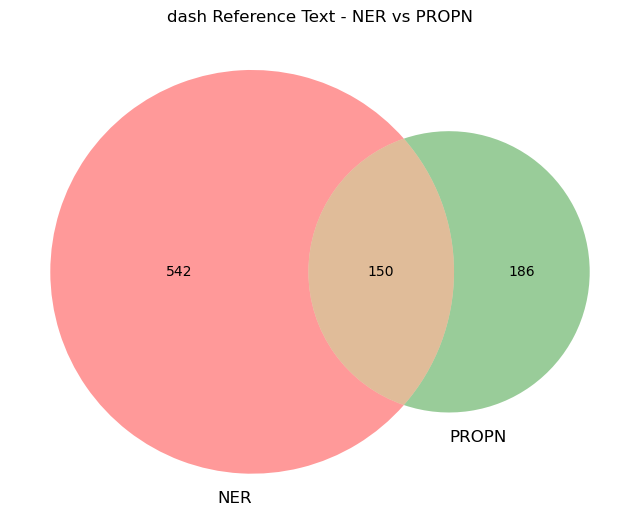

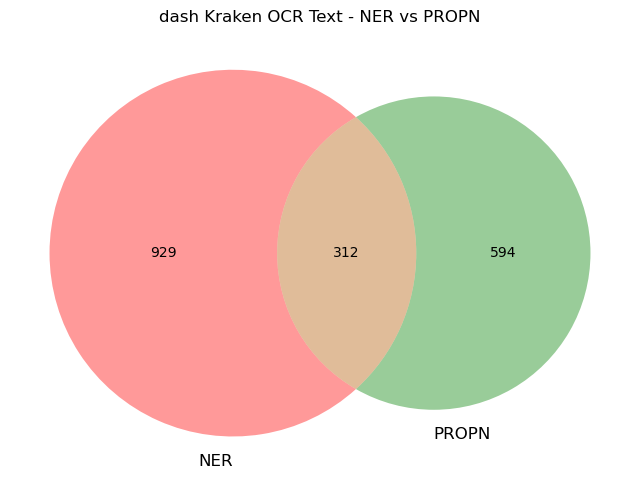

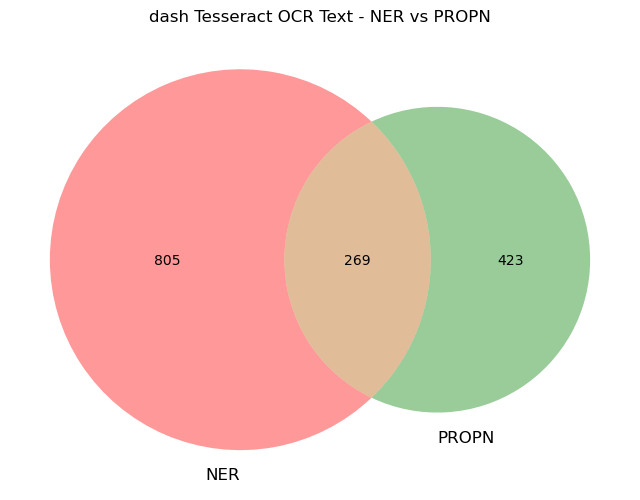

In [21]:
#visualisation les intersection entre ner et propn pour chaque text avec des diagrammes de Venn.

# Dessiner le diagramme de Venn pour la version de référence
plot_venn(ref_propn_entities, ref_propn_tokens, "dash Reference Text - NER vs PROPN")

# Dessiner le diagramme de Venn pour la version OCR de Kraken
plot_venn(kraken_propn_entities, kraken_propn_tokens, "dash Kraken OCR Text - NER vs PROPN")

# Dessiner le diagramme de Venn pour la version OCR de Tesseract
plot_venn(tesseract_propn_entities, tesseract_propn_tokens, "dash Tesseract OCR Text - NER vs PROPN")








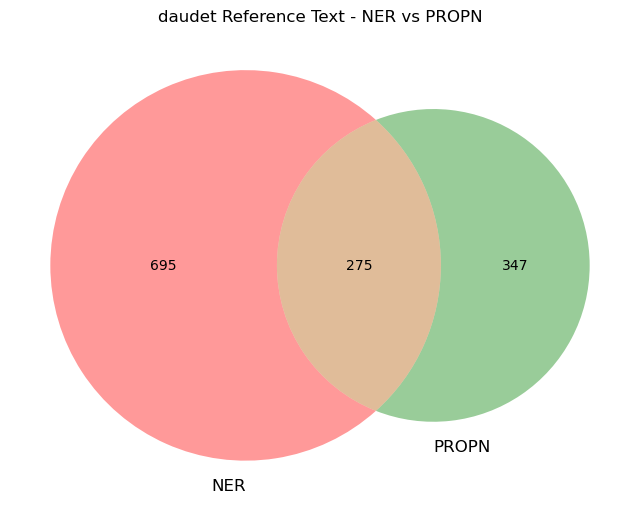

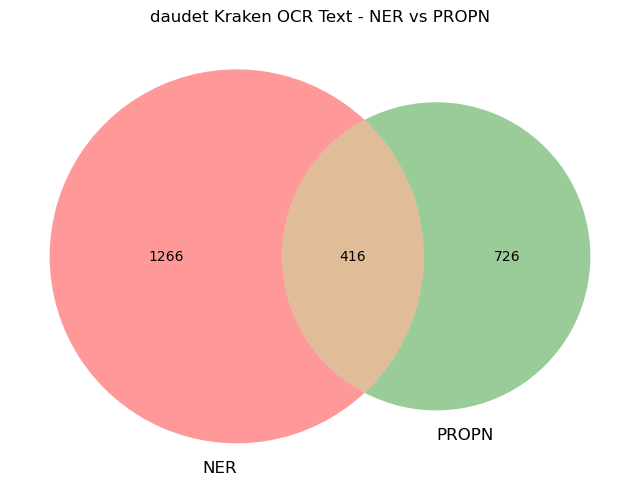

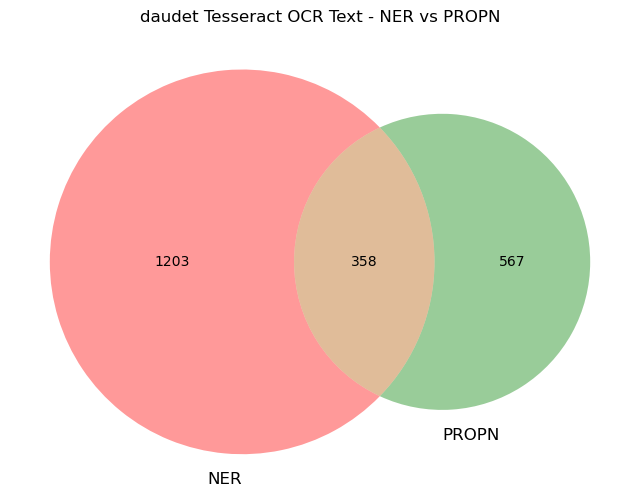

In [22]:
plot_venn(daudet_ref_propn_entities, daudet_ref_propn_tokens, "daudet Reference Text - NER vs PROPN")


plot_venn(daudet_kraken_propn_entities, daudet_kraken_propn_tokens, "daudet Kraken OCR Text - NER vs PROPN")


plot_venn(daudet_tesseract_propn_entities, daudet_tesseract_propn_tokens, "daudet Tesseract OCR Text - NER vs PROPN")


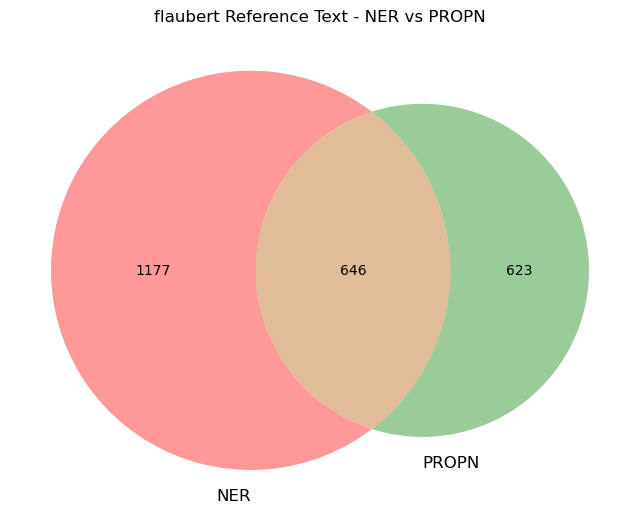

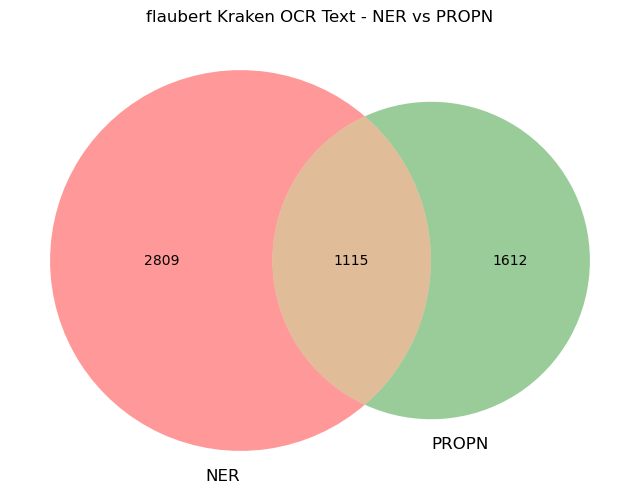

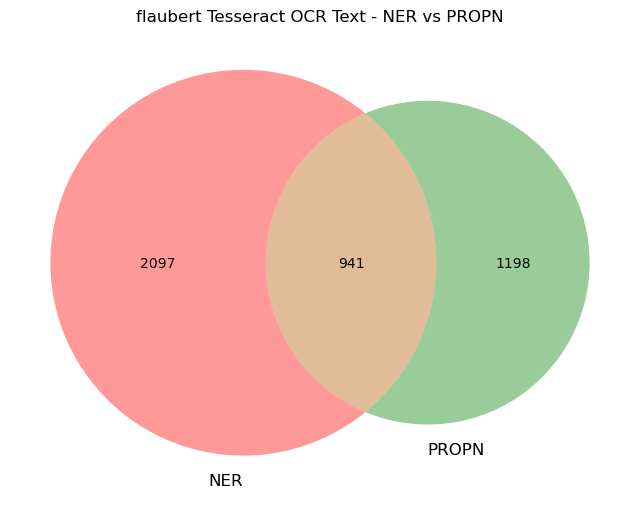

In [23]:
plot_venn(FLAUBERT_ref_propn_entities, FLAUBERT_ref_propn_tokens, "flaubert Reference Text - NER vs PROPN")


plot_venn(FLAUBERT_kraken_propn_entities, FLAUBERT_kraken_propn_tokens, "flaubert Kraken OCR Text - NER vs PROPN")


plot_venn(FLAUBERT_tesseract_propn_entities, FLAUBERT_tesseract_propn_tokens, "flaubert Tesseract OCR Text - NER vs PROPN")


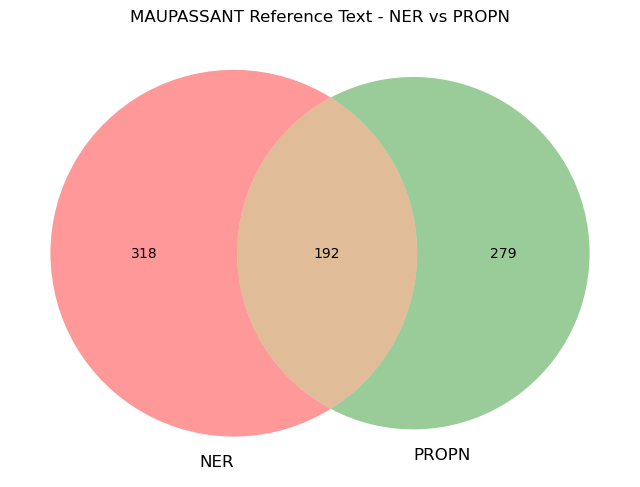

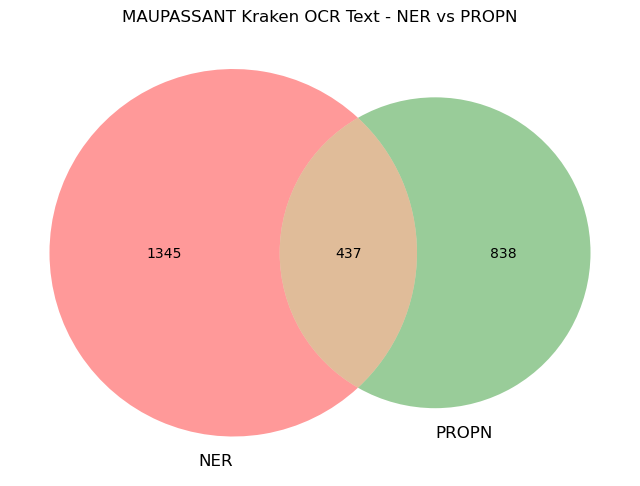

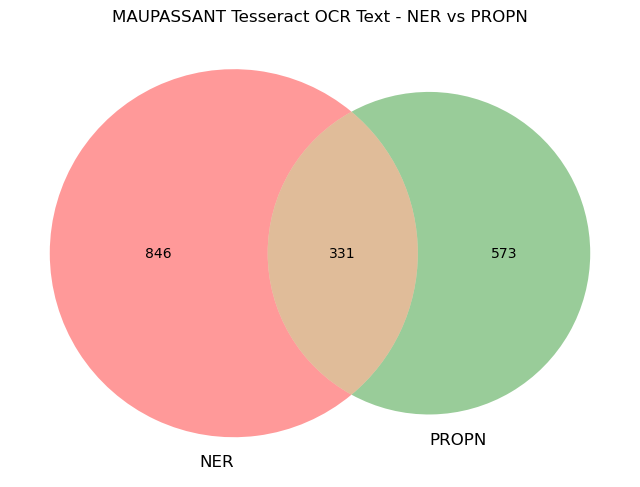

In [24]:
plot_venn(MAUPASSANT_ref_propn_entities, MAUPASSANT_ref_propn_tokens, "MAUPASSANT Reference Text - NER vs PROPN")


plot_venn(MAUPASSANT_kraken_propn_entities, MAUPASSANT_kraken_propn_tokens, "MAUPASSANT Kraken OCR Text - NER vs PROPN")


plot_venn(MAUPASSANT_tesseract_propn_entities, MAUPASSANT_tesseract_propn_tokens, "MAUPASSANT Tesseract OCR Text - NER vs PROPN")


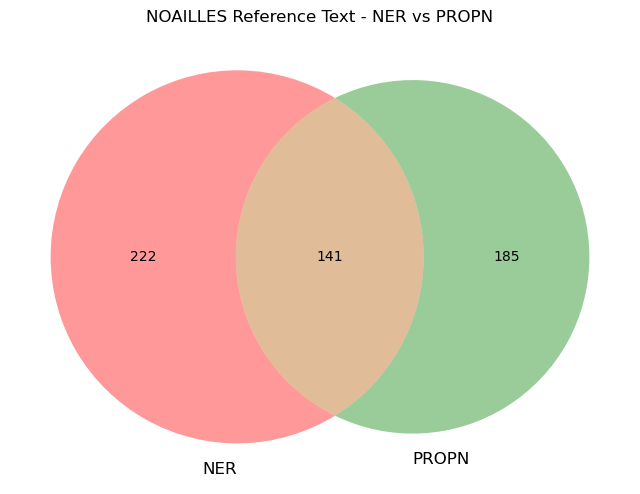

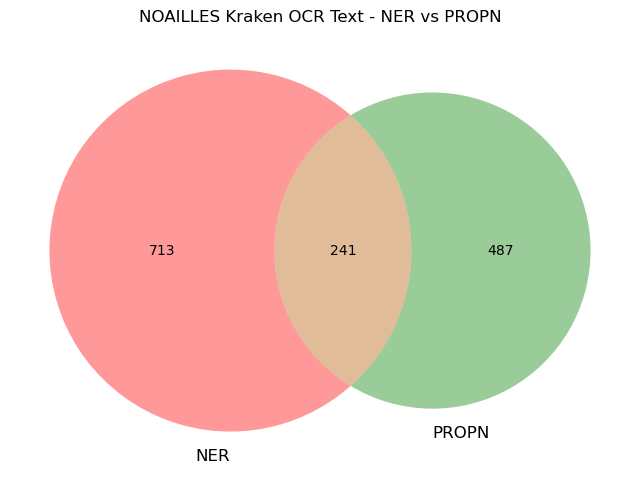

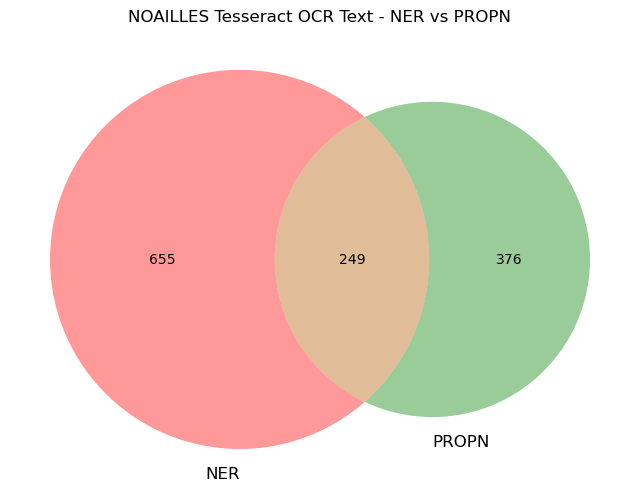

In [25]:
plot_venn(NOAILLES_ref_propn_entities, NOAILLES_ref_propn_tokens, "NOAILLES Reference Text - NER vs PROPN")


plot_venn(NOAILLES_kraken_propn_entities, NOAILLES_kraken_propn_tokens, "NOAILLES Kraken OCR Text - NER vs PROPN")


plot_venn(NOAILLES_tesseract_propn_entities, NOAILLES_tesseract_propn_tokens, "NOAILLES Tesseract OCR Text - NER vs PROPN")
